In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam,Adagrad
import pyro.poutine as poutine
from torchvision.utils import save_image

import matplotlib.pylab as plt

from PIL import Image, ImageOps # Module for image rotation (making use of PIL)

from utils.models import HMT

from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp

In [19]:
d = 2

In [20]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [21]:
#from utils.MiraBest import MiraBest
from utils.MiraBest_full import MiraBest_full
from utils.FRDEEP import FRDEEPF
from utils.data_downloader import dataloader_first_FRDEEP
from utils.data_downloader import dataloader_first
from utils.classification_function import classfication_procedure

import network_configurations.neural_net_conf_0_2_dropout as network

In [22]:
def dataloder_first_FRDEEP_PA0():
    array_data=np.load('ROTATED_IMAGES_TRAIN_IMAGES.npy')
    
    augmented_data=np.zeros((550*4,1,100,100))   
    
    for n in range(0,550):
        image_object=Image.fromarray(array_data[n,0,:,:])
        im_unflip_unmirror = image_object
        im_flip_unmirror = ImageOps.flip(image_object)
        im_unflip_mirror = ImageOps.mirror(image_object)
        im_flip_mirror = ImageOps.flip(Image.fromarray(np.array(im_unflip_mirror)))
        augmented_data[n*4,0,:,:]=np.array(image_object)[25:125,25:125]
        augmented_data[(n*4)+1,0,:,:]=np.array(im_flip_unmirror)[25:125,25:125]
        augmented_data[(n*4)+2,0,:,:]=np.array(im_unflip_unmirror)[25:125,25:125]
        augmented_data[(n*4)+3,0,:,:]=np.array(im_flip_mirror)[25:125,25:125]
            

    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))

    X=augmented_data



    # Have to add the test data to the code. The test data has to be mixed with the training data. 
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X])



    #--------------------Put the label set here as tensor y-----------------------------------
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x) # create your datset
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=50, shuffle=True) # create your dataloader
    
    array_test=np.load('ROTATED_IMAGES_TEST_IMAGES.npy')
    
    test_data_reduced=np.zeros((50,1,100,100))
    for k in range (0,50):
        test_data_reduced[k][0][:][:] = array_test[k][0][25:125,25:125]
    
    test_data_reduced=(test_data_reduced-np.min(test_data_reduced))/(np.max(test_data_reduced)-np.min(test_data_reduced))


    
    
    tensor_test = torch.stack([torch.Tensor(i) for i in test_data_reduced])





    
    first_augmented_dataset_test = torch.utils.data.TensorDataset(tensor_test) # create your datset
    
    first_dataloader_test = torch.utils.data.DataLoader(first_augmented_dataset_test,batch_size=50, shuffle=True) # create your
    
    return first_dataloader,first_dataloader_test

In [23]:
def inception_score():
    model = HMT().cuda()
    model.load_state_dict(torch.load('model.mod'))
    
    return model.eval()

In [24]:
inception_classifier = inception_score()

In [25]:
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = exp(avg_kl_d)
    return is_score

In [26]:

#---------------------------------------------------VAE CLASS DECLARATION------------------------------------------------------------
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # @David We have changed the latent space to 2-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim,h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim, use_cuda=True): # z_dim has been changed to 2
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        #For the first images add addition hidden layers
        self.encoder = network.Encoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure
        self.decoder = network.Decoder(x_dim, h_dim1, h_dim2, h_dim3, h_dim4, h_dim5, z_dim) #To check the layering structure

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # Do not touch this part for the time being this will be modified when doing the Semi-Supervised VAE     
    # define the model p(x|z)p(z)
    #-------------------------------------------------------------------------------------------------------------------
    #-----------------------------------------------Model Chunck--------------------------------------------------------
    #-------------------------------------------------------------------------------------------------------------------
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 10000))
    #------------------------------------------------------------------------------------------------------------------
    
    #------------------------------------------------------------------------------------------------------------------
    #--------------------------------------------------Guide Chunk-----------------------------------------------------
    #------------------------------------------------------------------------------------------------------------------
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    #------------------------------------------------------------------------------------------------------------------


    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


In [27]:
# ------------------------------------------------Initialisation of all the parameters-----------------------------------
# Fully Connected Layer network architecture parameterization
#d = 4 #Define the number of dimensions in the Bottleneck of the Variational Auto Encoder

#Learning Rate Configuration

#Use CUDA configuration
USE_CUDA = True

# Run only for a single iteration for testing 

# Define 
NUM_EPOCHS = 1 if smoke_test else 8000 #Remove the hardcoded [8000]
TEST_FREQUENCY = 5

#--------------------------------------------Defining the dataframe to save the logs--------------------------------------
data = np.zeros((5,8000)).T

columns = ['Epoch','Train_Loss', 'Test_Loss', 'Sigma_clipped','Inception_score']
df = pd.DataFrame(data, columns=columns)


#-----------------------------------------------------VAE initialisation--------------------------------------------------

vae = VAE(x_dim=10000,h_dim1=4096,h_dim2=2048,h_dim3=1024,h_dim4=512,h_dim5=256,z_dim=d,use_cuda=USE_CUDA)

#The VAE has to be initialised right before the evaluate(), single_image_sampler() and save_checkpoint() as they make use of VAE instance

# Note that the mini batch logic is handled by the data loader, we should duplicate the same logic of the data loader with the FIRST Database. The core of the training loop is svi.step(x). This is the data entry point. It should be noted that we have to change the looping structure to that of the mini batch structure that is used for the FIRST database.

# To do evaluate part afterwards

In [28]:
def evaluate(svi, test_loader, use_cuda=True):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x) #Data entry point <---------------------------------Data Entry Point
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [29]:
def single_image_sampler(z):
    single_sample_image = vae.decoder(z)
    image_array_single =single_sample_image.reshape(100,100).cpu().detach().numpy()
    temp_array=image_array_single
    plt.figure(figsize = (10,10))
    plt.imshow(image_array_single)
    plt.colorbar()
    plt.show()
    return image_array_single

In [30]:
#--------------------------------------------------Dataloader initialisation---------------------------------------------     
train_loader,test_loader = dataloder_first_FRDEEP_PA0()

In [31]:
def inception_scoring(d,limits):
    z_fr = torch.randn(100, d)

    for i in range (0,100):
        for j in range (0,d):
            z_fr[i,j] = np.random.uniform(limits[0,j],limits[1,j])
    
    sample1 = vae.decoder(z_fr.cuda()).cpu().detach().numpy().reshape(100,1,100,100)
    
    fullsize_image = np.zeros((100,1,150,150))

    for i in range (0,100):
        fullsize_image[i,0,25:125,25:125]=sample1[i,0,:,:]
    
    array_generated= torch.from_numpy(fullsize_image).float().to("cpu")

    valid_pred = inception_classifier(array_generated.cuda())
    m = nn.Softmax(dim=1)
    values=m(valid_pred).cpu().detach().numpy()
    score = calculate_inception_score(values)

    return score

In [32]:
def training_loop(LEARNING_RATE,NUM_EPOCHS,LEARNING_RATE_SEARCH):
    adam_args = {"lr": LEARNING_RATE}
    # optimizer = Adam(adam_args)   # The Adam optimizer is used as optimizer
    optimizer = Adagrad(adam_args)
    # setup the inference algorithm
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    pyro.clear_param_store() #VVIP clears out parameters eash time looping sequence is engaged

    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in range(NUM_EPOCHS):
        # total_epoch_loss_train = train(svi, epoch, train_loader)
        # ------------ To include Training Loop just for test -------------------
        epoch_loss = 0.
   
        for x in train_loader: # Note that _ is the labels only and x are the images.
        # if on GPU put mini-batch into CUDA memory
        
            x = x[0].cuda()
            # do ELBO gradient and accumulate loss
            epoch_loss += svi.step(x)
        
        # return epoch loss
        normalizer_train = len(train_loader.dataset)
    
        total_epoch_loss_train = epoch_loss / normalizer_train
      
        train_elbo.append(-total_epoch_loss_train)
    

        test_loss = 0.
  
        for x_test in test_loader:
  

            x_test = x_test[0].cuda()
     
            test_loss += svi.evaluate_loss(x_test) 
        normalizer_test = len(test_loader.dataset)
        total_epoch_loss_test = test_loss / normalizer_test
    
        incept_score = 0 

        limits = np.zeros((2,d))
        for i in range (0,d):
            limits[0,i]= -4
            limits[1,i]= 4
    
    
        incept_score = inception_scoring(d,limits) #Calls the inception score and calculates it.
    
    
    
        print("[epoch %03d]  average training loss: %.4f testing loss: %.4f inception score: %.4f" % (epoch, total_epoch_loss_train,total_epoch_loss_test,incept_score))
        
        if LEARNING_RATE_SEARCH == False:
            df['Epoch'][epoch]=epoch
            df['Train_Loss'][epoch]=total_epoch_loss_train
            df['Test_Loss'][epoch]=total_epoch_loss_test
            df['Inception_score'][epoch]=incept_score
    
            if epoch%10 == 0:
                df.to_csv('data_unsupervised_pa0_test_d'+str(d)+'.csv')
            
    return total_epoch_loss_train,total_epoch_loss_test,incept_score
    

In [33]:
(total_epoch_loss_train,total_epoch_loss_test,incept_score)=training_loop(0.000840,5000,False)

[epoch 000]  average training loss: 879.7492 testing loss: 144.3901 inception score: 1.0097
[epoch 001]  average training loss: 163.6863 testing loss: 144.6053 inception score: 1.0156
[epoch 002]  average training loss: 162.9092 testing loss: 147.4808 inception score: 1.0140
[epoch 003]  average training loss: 163.0517 testing loss: 145.0462 inception score: 1.0208
[epoch 004]  average training loss: 162.4993 testing loss: 144.1110 inception score: 1.0120
[epoch 005]  average training loss: 162.0482 testing loss: 143.6979 inception score: 1.0087
[epoch 006]  average training loss: 163.1033 testing loss: 145.3676 inception score: 1.0104
[epoch 007]  average training loss: 162.1134 testing loss: 145.1473 inception score: 1.0102
[epoch 008]  average training loss: 161.9771 testing loss: 143.0478 inception score: 1.0161
[epoch 009]  average training loss: 162.1164 testing loss: 143.1406 inception score: 1.0133
[epoch 010]  average training loss: 161.9785 testing loss: 143.9031 inception sc

[epoch 090]  average training loss: 142.2392 testing loss: 132.3385 inception score: 1.1104
[epoch 091]  average training loss: 142.3746 testing loss: 131.2602 inception score: 1.1120
[epoch 092]  average training loss: 142.3530 testing loss: 132.4291 inception score: 1.0863
[epoch 093]  average training loss: 142.2097 testing loss: 131.1552 inception score: 1.0756
[epoch 094]  average training loss: 142.4049 testing loss: 133.4210 inception score: 1.0984
[epoch 095]  average training loss: 142.1124 testing loss: 131.7224 inception score: 1.1074
[epoch 096]  average training loss: 142.1472 testing loss: 131.8057 inception score: 1.0768
[epoch 097]  average training loss: 142.0897 testing loss: 130.9311 inception score: 1.0748
[epoch 098]  average training loss: 142.0514 testing loss: 131.9619 inception score: 1.0945
[epoch 099]  average training loss: 141.9296 testing loss: 131.5977 inception score: 1.0950
[epoch 100]  average training loss: 141.8472 testing loss: 130.9939 inception sc

[epoch 180]  average training loss: 140.0476 testing loss: 129.5960 inception score: 1.0874
[epoch 181]  average training loss: 139.8635 testing loss: 130.9771 inception score: 1.1054
[epoch 182]  average training loss: 139.9185 testing loss: 130.0690 inception score: 1.0970
[epoch 183]  average training loss: 139.8926 testing loss: 131.0111 inception score: 1.0878
[epoch 184]  average training loss: 139.8752 testing loss: 131.4128 inception score: 1.1221
[epoch 185]  average training loss: 140.0550 testing loss: 129.8069 inception score: 1.0972
[epoch 186]  average training loss: 139.8945 testing loss: 130.3113 inception score: 1.0984
[epoch 187]  average training loss: 139.9446 testing loss: 130.1994 inception score: 1.1143
[epoch 188]  average training loss: 139.7597 testing loss: 129.7561 inception score: 1.1053
[epoch 189]  average training loss: 139.9196 testing loss: 130.1431 inception score: 1.1014
[epoch 190]  average training loss: 139.9215 testing loss: 129.0128 inception sc

[epoch 270]  average training loss: 139.1578 testing loss: 128.9853 inception score: 1.1179
[epoch 271]  average training loss: 139.1791 testing loss: 130.1007 inception score: 1.1034
[epoch 272]  average training loss: 139.0796 testing loss: 129.9214 inception score: 1.1281
[epoch 273]  average training loss: 139.1423 testing loss: 129.6126 inception score: 1.0971
[epoch 274]  average training loss: 139.0253 testing loss: 128.9926 inception score: 1.1161
[epoch 275]  average training loss: 138.9835 testing loss: 129.8207 inception score: 1.1390
[epoch 276]  average training loss: 139.0768 testing loss: 128.9034 inception score: 1.1290
[epoch 277]  average training loss: 139.2561 testing loss: 130.0779 inception score: 1.1197
[epoch 278]  average training loss: 139.1489 testing loss: 129.7891 inception score: 1.1065
[epoch 279]  average training loss: 139.0260 testing loss: 129.3195 inception score: 1.1188
[epoch 280]  average training loss: 139.0674 testing loss: 129.2603 inception sc

[epoch 360]  average training loss: 138.3789 testing loss: 130.2013 inception score: 1.1493
[epoch 361]  average training loss: 138.3802 testing loss: 129.6026 inception score: 1.1414
[epoch 362]  average training loss: 138.2819 testing loss: 129.2689 inception score: 1.0995
[epoch 363]  average training loss: 138.4447 testing loss: 129.4043 inception score: 1.1289
[epoch 364]  average training loss: 138.4922 testing loss: 129.0370 inception score: 1.1668
[epoch 365]  average training loss: 138.2448 testing loss: 130.0465 inception score: 1.1452
[epoch 366]  average training loss: 138.3629 testing loss: 129.4133 inception score: 1.1011
[epoch 367]  average training loss: 138.5180 testing loss: 129.4481 inception score: 1.1450
[epoch 368]  average training loss: 138.4464 testing loss: 128.7079 inception score: 1.1240
[epoch 369]  average training loss: 138.3981 testing loss: 129.7820 inception score: 1.1110
[epoch 370]  average training loss: 138.4361 testing loss: 128.6430 inception sc

[epoch 450]  average training loss: 138.0757 testing loss: 129.6782 inception score: 1.1375
[epoch 451]  average training loss: 138.0684 testing loss: 129.2584 inception score: 1.1277
[epoch 452]  average training loss: 138.1554 testing loss: 129.2287 inception score: 1.1308
[epoch 453]  average training loss: 137.9952 testing loss: 129.1269 inception score: 1.1255
[epoch 454]  average training loss: 137.9444 testing loss: 129.2864 inception score: 1.1208
[epoch 455]  average training loss: 138.0058 testing loss: 128.5635 inception score: 1.1386
[epoch 456]  average training loss: 137.9435 testing loss: 130.1246 inception score: 1.1087
[epoch 457]  average training loss: 138.2503 testing loss: 128.8865 inception score: 1.1259
[epoch 458]  average training loss: 137.9568 testing loss: 129.2343 inception score: 1.1505
[epoch 459]  average training loss: 138.0497 testing loss: 129.4362 inception score: 1.1401
[epoch 460]  average training loss: 137.9558 testing loss: 130.0438 inception sc

[epoch 540]  average training loss: 137.5322 testing loss: 128.9849 inception score: 1.1357
[epoch 541]  average training loss: 137.5980 testing loss: 129.0528 inception score: 1.1321
[epoch 542]  average training loss: 137.5967 testing loss: 129.3470 inception score: 1.1119
[epoch 543]  average training loss: 137.7282 testing loss: 129.6646 inception score: 1.1362
[epoch 544]  average training loss: 137.6186 testing loss: 129.1272 inception score: 1.1121
[epoch 545]  average training loss: 137.7540 testing loss: 129.4320 inception score: 1.1452
[epoch 546]  average training loss: 137.4729 testing loss: 129.4774 inception score: 1.1280
[epoch 547]  average training loss: 137.5844 testing loss: 129.3748 inception score: 1.1235
[epoch 548]  average training loss: 137.5029 testing loss: 128.9646 inception score: 1.1181
[epoch 549]  average training loss: 137.5452 testing loss: 130.0974 inception score: 1.1362
[epoch 550]  average training loss: 137.6817 testing loss: 129.1525 inception sc

[epoch 630]  average training loss: 137.4820 testing loss: 129.8100 inception score: 1.1346
[epoch 631]  average training loss: 137.3470 testing loss: 129.1645 inception score: 1.1343
[epoch 632]  average training loss: 137.4861 testing loss: 128.9691 inception score: 1.1541
[epoch 633]  average training loss: 137.2382 testing loss: 128.4442 inception score: 1.1544
[epoch 634]  average training loss: 137.3607 testing loss: 128.6290 inception score: 1.1263
[epoch 635]  average training loss: 137.2850 testing loss: 128.7640 inception score: 1.1464
[epoch 636]  average training loss: 137.3687 testing loss: 130.3175 inception score: 1.1538
[epoch 637]  average training loss: 137.2824 testing loss: 128.1132 inception score: 1.1318
[epoch 638]  average training loss: 137.6709 testing loss: 128.6542 inception score: 1.1396
[epoch 639]  average training loss: 137.2603 testing loss: 129.9339 inception score: 1.1238
[epoch 640]  average training loss: 137.2622 testing loss: 128.9737 inception sc

[epoch 720]  average training loss: 137.2088 testing loss: 128.3275 inception score: 1.1552
[epoch 721]  average training loss: 137.2171 testing loss: 128.3459 inception score: 1.1425
[epoch 722]  average training loss: 136.9398 testing loss: 128.8167 inception score: 1.1389
[epoch 723]  average training loss: 137.0439 testing loss: 128.1563 inception score: 1.1363
[epoch 724]  average training loss: 136.9650 testing loss: 129.1239 inception score: 1.1362
[epoch 725]  average training loss: 137.0704 testing loss: 128.3771 inception score: 1.1366
[epoch 726]  average training loss: 137.1387 testing loss: 128.9545 inception score: 1.1712
[epoch 727]  average training loss: 137.0113 testing loss: 129.4756 inception score: 1.1501
[epoch 728]  average training loss: 137.2907 testing loss: 128.2397 inception score: 1.1368
[epoch 729]  average training loss: 137.0212 testing loss: 128.8349 inception score: 1.1588
[epoch 730]  average training loss: 137.1743 testing loss: 129.2752 inception sc

[epoch 810]  average training loss: 136.7261 testing loss: 128.5157 inception score: 1.1736
[epoch 811]  average training loss: 137.0457 testing loss: 128.3868 inception score: 1.1622
[epoch 812]  average training loss: 136.8670 testing loss: 128.7726 inception score: 1.1743
[epoch 813]  average training loss: 137.0111 testing loss: 128.2404 inception score: 1.1445
[epoch 814]  average training loss: 136.8328 testing loss: 129.0133 inception score: 1.1599
[epoch 815]  average training loss: 136.8978 testing loss: 128.4527 inception score: 1.1428
[epoch 816]  average training loss: 136.8071 testing loss: 128.7011 inception score: 1.1344
[epoch 817]  average training loss: 136.8075 testing loss: 128.1941 inception score: 1.1616
[epoch 818]  average training loss: 136.9639 testing loss: 129.4533 inception score: 1.1627
[epoch 819]  average training loss: 136.9530 testing loss: 129.0468 inception score: 1.1298
[epoch 820]  average training loss: 136.8596 testing loss: 128.8141 inception sc

[epoch 900]  average training loss: 136.8197 testing loss: 128.7899 inception score: 1.1476
[epoch 901]  average training loss: 136.5636 testing loss: 128.8630 inception score: 1.1496
[epoch 902]  average training loss: 136.7651 testing loss: 128.5050 inception score: 1.1613
[epoch 903]  average training loss: 136.7928 testing loss: 128.4846 inception score: 1.1614
[epoch 904]  average training loss: 136.6930 testing loss: 128.3334 inception score: 1.1371
[epoch 905]  average training loss: 136.7171 testing loss: 129.0315 inception score: 1.1381
[epoch 906]  average training loss: 136.6496 testing loss: 129.6748 inception score: 1.1165
[epoch 907]  average training loss: 136.6907 testing loss: 129.1542 inception score: 1.1395
[epoch 908]  average training loss: 136.6791 testing loss: 129.0093 inception score: 1.1381
[epoch 909]  average training loss: 136.6053 testing loss: 129.9318 inception score: 1.1539
[epoch 910]  average training loss: 136.5376 testing loss: 128.7339 inception sc

[epoch 990]  average training loss: 136.6314 testing loss: 128.4265 inception score: 1.2094
[epoch 991]  average training loss: 136.5258 testing loss: 128.5280 inception score: 1.1698
[epoch 992]  average training loss: 136.6277 testing loss: 128.2735 inception score: 1.1787
[epoch 993]  average training loss: 136.6025 testing loss: 129.3098 inception score: 1.1766
[epoch 994]  average training loss: 136.5408 testing loss: 128.8334 inception score: 1.1674
[epoch 995]  average training loss: 136.5522 testing loss: 128.9049 inception score: 1.1532
[epoch 996]  average training loss: 136.5208 testing loss: 129.3930 inception score: 1.1364
[epoch 997]  average training loss: 136.5786 testing loss: 128.1062 inception score: 1.1339
[epoch 998]  average training loss: 136.7553 testing loss: 128.0388 inception score: 1.1394
[epoch 999]  average training loss: 136.4867 testing loss: 128.1855 inception score: 1.1830
[epoch 1000]  average training loss: 136.6013 testing loss: 128.2693 inception s

[epoch 1079]  average training loss: 136.3817 testing loss: 128.3217 inception score: 1.1990
[epoch 1080]  average training loss: 136.3512 testing loss: 129.1359 inception score: 1.1753
[epoch 1081]  average training loss: 136.1414 testing loss: 128.6360 inception score: 1.1982
[epoch 1082]  average training loss: 136.3731 testing loss: 127.8266 inception score: 1.1525
[epoch 1083]  average training loss: 136.2543 testing loss: 128.5599 inception score: 1.1296
[epoch 1084]  average training loss: 136.4828 testing loss: 128.8771 inception score: 1.1461
[epoch 1085]  average training loss: 136.0333 testing loss: 128.7707 inception score: 1.1584
[epoch 1086]  average training loss: 136.5663 testing loss: 128.9279 inception score: 1.1711
[epoch 1087]  average training loss: 136.3892 testing loss: 128.7677 inception score: 1.1453
[epoch 1088]  average training loss: 136.5149 testing loss: 128.5364 inception score: 1.1742
[epoch 1089]  average training loss: 136.4670 testing loss: 128.7915 i

[epoch 1168]  average training loss: 136.5188 testing loss: 128.7186 inception score: 1.1878
[epoch 1169]  average training loss: 136.3167 testing loss: 129.0802 inception score: 1.1415
[epoch 1170]  average training loss: 136.4752 testing loss: 128.9370 inception score: 1.1891
[epoch 1171]  average training loss: 136.2280 testing loss: 129.2556 inception score: 1.1642
[epoch 1172]  average training loss: 136.2010 testing loss: 128.8909 inception score: 1.1701
[epoch 1173]  average training loss: 136.1849 testing loss: 129.5617 inception score: 1.1679
[epoch 1174]  average training loss: 136.1534 testing loss: 127.9760 inception score: 1.1749
[epoch 1175]  average training loss: 136.2308 testing loss: 128.6696 inception score: 1.1540
[epoch 1176]  average training loss: 136.2545 testing loss: 129.1428 inception score: 1.1813
[epoch 1177]  average training loss: 136.2163 testing loss: 129.2839 inception score: 1.1491
[epoch 1178]  average training loss: 136.2556 testing loss: 129.1446 i

[epoch 1257]  average training loss: 136.1620 testing loss: 128.6299 inception score: 1.1908
[epoch 1258]  average training loss: 135.9955 testing loss: 128.8777 inception score: 1.1749
[epoch 1259]  average training loss: 136.3461 testing loss: 128.8532 inception score: 1.1898
[epoch 1260]  average training loss: 136.0986 testing loss: 127.8830 inception score: 1.1642
[epoch 1261]  average training loss: 135.9572 testing loss: 128.8669 inception score: 1.1961
[epoch 1262]  average training loss: 136.0461 testing loss: 128.0999 inception score: 1.1762
[epoch 1263]  average training loss: 136.3742 testing loss: 128.5704 inception score: 1.1824
[epoch 1264]  average training loss: 136.1577 testing loss: 128.8089 inception score: 1.1423
[epoch 1265]  average training loss: 136.0635 testing loss: 128.9065 inception score: 1.1784
[epoch 1266]  average training loss: 135.8931 testing loss: 128.3447 inception score: 1.1896
[epoch 1267]  average training loss: 136.2128 testing loss: 128.5968 i

[epoch 1346]  average training loss: 135.8522 testing loss: 129.1195 inception score: 1.1868
[epoch 1347]  average training loss: 135.8392 testing loss: 129.3057 inception score: 1.1699
[epoch 1348]  average training loss: 136.1119 testing loss: 128.9589 inception score: 1.1892
[epoch 1349]  average training loss: 135.9450 testing loss: 128.0890 inception score: 1.1799
[epoch 1350]  average training loss: 136.0613 testing loss: 129.2425 inception score: 1.1700
[epoch 1351]  average training loss: 135.6574 testing loss: 128.5248 inception score: 1.1637
[epoch 1352]  average training loss: 135.9360 testing loss: 128.3119 inception score: 1.1673
[epoch 1353]  average training loss: 135.9190 testing loss: 128.4324 inception score: 1.1641
[epoch 1354]  average training loss: 136.0412 testing loss: 128.8181 inception score: 1.1924
[epoch 1355]  average training loss: 136.0801 testing loss: 129.2474 inception score: 1.1648
[epoch 1356]  average training loss: 135.9626 testing loss: 128.0081 i

[epoch 1435]  average training loss: 135.9093 testing loss: 128.8458 inception score: 1.1432
[epoch 1436]  average training loss: 135.6186 testing loss: 128.7725 inception score: 1.1920
[epoch 1437]  average training loss: 135.7790 testing loss: 128.6651 inception score: 1.1930
[epoch 1438]  average training loss: 135.6560 testing loss: 128.6224 inception score: 1.1788
[epoch 1439]  average training loss: 135.5536 testing loss: 128.5052 inception score: 1.1564
[epoch 1440]  average training loss: 135.6744 testing loss: 128.8844 inception score: 1.1820
[epoch 1441]  average training loss: 135.8622 testing loss: 128.8129 inception score: 1.1784
[epoch 1442]  average training loss: 135.5966 testing loss: 129.5071 inception score: 1.1642
[epoch 1443]  average training loss: 135.8408 testing loss: 128.3071 inception score: 1.1915
[epoch 1444]  average training loss: 135.8894 testing loss: 128.0003 inception score: 1.1724
[epoch 1445]  average training loss: 135.6754 testing loss: 128.9182 i

[epoch 1524]  average training loss: 136.0914 testing loss: 128.9796 inception score: 1.1433
[epoch 1525]  average training loss: 135.4749 testing loss: 129.1754 inception score: 1.1795
[epoch 1526]  average training loss: 135.5302 testing loss: 128.4894 inception score: 1.1738
[epoch 1527]  average training loss: 135.5963 testing loss: 127.6990 inception score: 1.1707
[epoch 1528]  average training loss: 135.6221 testing loss: 128.8388 inception score: 1.1686
[epoch 1529]  average training loss: 135.3914 testing loss: 129.3716 inception score: 1.1907
[epoch 1530]  average training loss: 135.4965 testing loss: 128.2718 inception score: 1.1901
[epoch 1531]  average training loss: 135.5309 testing loss: 128.6565 inception score: 1.2377
[epoch 1532]  average training loss: 135.5919 testing loss: 128.6110 inception score: 1.2032
[epoch 1533]  average training loss: 135.7944 testing loss: 128.0982 inception score: 1.1907
[epoch 1534]  average training loss: 135.6505 testing loss: 128.8706 i

[epoch 1613]  average training loss: 135.0334 testing loss: 128.8903 inception score: 1.1698
[epoch 1614]  average training loss: 135.3860 testing loss: 128.1141 inception score: 1.1895
[epoch 1615]  average training loss: 135.1685 testing loss: 127.6153 inception score: 1.1580
[epoch 1616]  average training loss: 135.4043 testing loss: 129.0504 inception score: 1.1820
[epoch 1617]  average training loss: 135.1814 testing loss: 128.5253 inception score: 1.1649
[epoch 1618]  average training loss: 135.3601 testing loss: 127.8591 inception score: 1.1560
[epoch 1619]  average training loss: 135.2499 testing loss: 129.1993 inception score: 1.1709
[epoch 1620]  average training loss: 135.2940 testing loss: 128.7576 inception score: 1.1573
[epoch 1621]  average training loss: 135.1849 testing loss: 128.2877 inception score: 1.1936
[epoch 1622]  average training loss: 135.2099 testing loss: 128.7760 inception score: 1.2033
[epoch 1623]  average training loss: 135.2410 testing loss: 129.3795 i

[epoch 1702]  average training loss: 134.8744 testing loss: 129.0640 inception score: 1.1741
[epoch 1703]  average training loss: 134.7870 testing loss: 128.2270 inception score: 1.1685
[epoch 1704]  average training loss: 135.1265 testing loss: 129.0074 inception score: 1.2034
[epoch 1705]  average training loss: 135.0449 testing loss: 129.3584 inception score: 1.1654
[epoch 1706]  average training loss: 134.8557 testing loss: 129.3118 inception score: 1.1666
[epoch 1707]  average training loss: 135.0227 testing loss: 128.6362 inception score: 1.1595
[epoch 1708]  average training loss: 134.7921 testing loss: 129.3619 inception score: 1.1839
[epoch 1709]  average training loss: 135.0068 testing loss: 128.5969 inception score: 1.1604
[epoch 1710]  average training loss: 135.0119 testing loss: 128.5309 inception score: 1.1694
[epoch 1711]  average training loss: 134.9705 testing loss: 128.6631 inception score: 1.1792
[epoch 1712]  average training loss: 134.8559 testing loss: 129.0295 i

[epoch 1791]  average training loss: 134.4708 testing loss: 128.5533 inception score: 1.1609
[epoch 1792]  average training loss: 134.5021 testing loss: 128.6044 inception score: 1.1656
[epoch 1793]  average training loss: 134.4142 testing loss: 127.9960 inception score: 1.1329
[epoch 1794]  average training loss: 134.4581 testing loss: 129.0417 inception score: 1.1688
[epoch 1795]  average training loss: 134.1817 testing loss: 128.1501 inception score: 1.1730
[epoch 1796]  average training loss: 134.5247 testing loss: 128.8872 inception score: 1.1688
[epoch 1797]  average training loss: 134.5496 testing loss: 128.2922 inception score: 1.1747
[epoch 1798]  average training loss: 134.2281 testing loss: 128.8668 inception score: 1.1845
[epoch 1799]  average training loss: 134.3210 testing loss: 129.0718 inception score: 1.1668
[epoch 1800]  average training loss: 134.4982 testing loss: 129.6450 inception score: 1.1630
[epoch 1801]  average training loss: 134.4712 testing loss: 128.8327 i

[epoch 1880]  average training loss: 133.5007 testing loss: 127.3966 inception score: 1.1557
[epoch 1881]  average training loss: 133.6081 testing loss: 128.1615 inception score: 1.1928
[epoch 1882]  average training loss: 133.3190 testing loss: 128.2838 inception score: 1.1410
[epoch 1883]  average training loss: 133.4291 testing loss: 128.4073 inception score: 1.1245
[epoch 1884]  average training loss: 133.4260 testing loss: 127.7844 inception score: 1.1687
[epoch 1885]  average training loss: 133.5389 testing loss: 127.8436 inception score: 1.1821
[epoch 1886]  average training loss: 133.3354 testing loss: 127.4429 inception score: 1.1621
[epoch 1887]  average training loss: 133.2185 testing loss: 127.6437 inception score: 1.1470
[epoch 1888]  average training loss: 133.1645 testing loss: 127.2055 inception score: 1.1598
[epoch 1889]  average training loss: 133.1969 testing loss: 126.7578 inception score: 1.1614
[epoch 1890]  average training loss: 133.2155 testing loss: 128.1723 i

[epoch 1969]  average training loss: 132.3011 testing loss: 126.0365 inception score: 1.1511
[epoch 1970]  average training loss: 132.2208 testing loss: 126.9440 inception score: 1.1647
[epoch 1971]  average training loss: 132.0091 testing loss: 126.8355 inception score: 1.1575
[epoch 1972]  average training loss: 132.1047 testing loss: 126.5178 inception score: 1.1275
[epoch 1973]  average training loss: 132.1075 testing loss: 126.8977 inception score: 1.1675
[epoch 1974]  average training loss: 132.1312 testing loss: 126.9798 inception score: 1.1723
[epoch 1975]  average training loss: 132.1973 testing loss: 126.9084 inception score: 1.1709
[epoch 1976]  average training loss: 132.1991 testing loss: 126.9178 inception score: 1.1535
[epoch 1977]  average training loss: 132.2409 testing loss: 127.0296 inception score: 1.1603
[epoch 1978]  average training loss: 132.1355 testing loss: 126.6242 inception score: 1.1905
[epoch 1979]  average training loss: 131.9799 testing loss: 126.6226 i

[epoch 2058]  average training loss: 131.4310 testing loss: 127.7038 inception score: 1.1522
[epoch 2059]  average training loss: 131.6732 testing loss: 126.7734 inception score: 1.1558
[epoch 2060]  average training loss: 131.5849 testing loss: 127.0956 inception score: 1.1908
[epoch 2061]  average training loss: 131.5118 testing loss: 126.8053 inception score: 1.1544
[epoch 2062]  average training loss: 131.4932 testing loss: 127.7192 inception score: 1.1580
[epoch 2063]  average training loss: 131.7707 testing loss: 126.3620 inception score: 1.1617
[epoch 2064]  average training loss: 131.6424 testing loss: 126.8134 inception score: 1.1580
[epoch 2065]  average training loss: 131.4943 testing loss: 126.8549 inception score: 1.1805
[epoch 2066]  average training loss: 131.4966 testing loss: 126.7945 inception score: 1.1562
[epoch 2067]  average training loss: 131.7527 testing loss: 127.4462 inception score: 1.1840
[epoch 2068]  average training loss: 131.2233 testing loss: 127.4468 i

[epoch 2147]  average training loss: 131.1479 testing loss: 126.7803 inception score: 1.1491
[epoch 2148]  average training loss: 131.2806 testing loss: 127.1383 inception score: 1.1644
[epoch 2149]  average training loss: 131.1912 testing loss: 126.5076 inception score: 1.1736
[epoch 2150]  average training loss: 131.1928 testing loss: 126.8022 inception score: 1.1535
[epoch 2151]  average training loss: 131.1991 testing loss: 126.4444 inception score: 1.1655
[epoch 2152]  average training loss: 131.3361 testing loss: 127.4001 inception score: 1.1781
[epoch 2153]  average training loss: 131.0598 testing loss: 125.8860 inception score: 1.1808
[epoch 2154]  average training loss: 131.2534 testing loss: 126.9197 inception score: 1.1806
[epoch 2155]  average training loss: 130.8407 testing loss: 127.4739 inception score: 1.1667
[epoch 2156]  average training loss: 131.2483 testing loss: 126.3230 inception score: 1.1716
[epoch 2157]  average training loss: 130.8761 testing loss: 126.4624 i

[epoch 2236]  average training loss: 130.9676 testing loss: 126.4009 inception score: 1.1729
[epoch 2237]  average training loss: 130.7896 testing loss: 126.7974 inception score: 1.1893
[epoch 2238]  average training loss: 130.8956 testing loss: 126.1021 inception score: 1.1865
[epoch 2239]  average training loss: 131.0260 testing loss: 127.2240 inception score: 1.1557
[epoch 2240]  average training loss: 130.7325 testing loss: 125.6669 inception score: 1.1756
[epoch 2241]  average training loss: 131.1511 testing loss: 126.2803 inception score: 1.1826
[epoch 2242]  average training loss: 130.8590 testing loss: 125.9912 inception score: 1.1536
[epoch 2243]  average training loss: 130.6375 testing loss: 126.5692 inception score: 1.1669
[epoch 2244]  average training loss: 130.7337 testing loss: 127.1761 inception score: 1.1560
[epoch 2245]  average training loss: 130.7702 testing loss: 125.9020 inception score: 1.1729
[epoch 2246]  average training loss: 130.7868 testing loss: 126.2273 i

[epoch 2325]  average training loss: 130.5518 testing loss: 126.4480 inception score: 1.1782
[epoch 2326]  average training loss: 130.7920 testing loss: 127.1067 inception score: 1.1682
[epoch 2327]  average training loss: 130.3137 testing loss: 126.4405 inception score: 1.1766
[epoch 2328]  average training loss: 130.5720 testing loss: 126.7120 inception score: 1.1771
[epoch 2329]  average training loss: 130.7852 testing loss: 126.2069 inception score: 1.1733
[epoch 2330]  average training loss: 130.4799 testing loss: 127.5665 inception score: 1.2053
[epoch 2331]  average training loss: 130.3729 testing loss: 125.8757 inception score: 1.1879
[epoch 2332]  average training loss: 130.5428 testing loss: 126.3454 inception score: 1.1790
[epoch 2333]  average training loss: 130.4205 testing loss: 126.9561 inception score: 1.1949
[epoch 2334]  average training loss: 130.2239 testing loss: 126.8502 inception score: 1.1545
[epoch 2335]  average training loss: 130.4455 testing loss: 126.9444 i

[epoch 2414]  average training loss: 130.0982 testing loss: 126.1623 inception score: 1.1860
[epoch 2415]  average training loss: 130.4452 testing loss: 126.3545 inception score: 1.1847
[epoch 2416]  average training loss: 130.3734 testing loss: 126.9688 inception score: 1.1925
[epoch 2417]  average training loss: 130.2551 testing loss: 127.8862 inception score: 1.1991
[epoch 2418]  average training loss: 130.5272 testing loss: 126.7182 inception score: 1.1933
[epoch 2419]  average training loss: 130.3171 testing loss: 126.6455 inception score: 1.1876
[epoch 2420]  average training loss: 130.1312 testing loss: 127.3031 inception score: 1.1884
[epoch 2421]  average training loss: 130.2566 testing loss: 126.6006 inception score: 1.2073
[epoch 2422]  average training loss: 130.1553 testing loss: 126.3537 inception score: 1.1808
[epoch 2423]  average training loss: 130.2077 testing loss: 126.4177 inception score: 1.2048
[epoch 2424]  average training loss: 130.2366 testing loss: 127.1929 i

[epoch 2503]  average training loss: 130.3330 testing loss: 125.0179 inception score: 1.1737
[epoch 2504]  average training loss: 130.0600 testing loss: 126.6520 inception score: 1.1591
[epoch 2505]  average training loss: 130.1498 testing loss: 125.8578 inception score: 1.1743
[epoch 2506]  average training loss: 130.0051 testing loss: 126.5105 inception score: 1.1728
[epoch 2507]  average training loss: 129.9410 testing loss: 127.2574 inception score: 1.1562
[epoch 2508]  average training loss: 129.7653 testing loss: 126.2130 inception score: 1.1967
[epoch 2509]  average training loss: 130.1192 testing loss: 126.3772 inception score: 1.1793
[epoch 2510]  average training loss: 129.9242 testing loss: 126.5133 inception score: 1.1671
[epoch 2511]  average training loss: 129.9355 testing loss: 128.0626 inception score: 1.2125
[epoch 2512]  average training loss: 130.2414 testing loss: 126.3807 inception score: 1.1790
[epoch 2513]  average training loss: 129.9478 testing loss: 126.5320 i

[epoch 2592]  average training loss: 129.8043 testing loss: 125.7906 inception score: 1.2051
[epoch 2593]  average training loss: 129.5720 testing loss: 126.1356 inception score: 1.2024
[epoch 2594]  average training loss: 129.6601 testing loss: 126.7360 inception score: 1.1689
[epoch 2595]  average training loss: 129.8806 testing loss: 127.3242 inception score: 1.1587
[epoch 2596]  average training loss: 129.5466 testing loss: 126.4100 inception score: 1.1716
[epoch 2597]  average training loss: 129.5178 testing loss: 126.2206 inception score: 1.1837
[epoch 2598]  average training loss: 129.8480 testing loss: 126.6661 inception score: 1.1656
[epoch 2599]  average training loss: 129.6206 testing loss: 126.4646 inception score: 1.1853
[epoch 2600]  average training loss: 129.7510 testing loss: 126.6582 inception score: 1.1685
[epoch 2601]  average training loss: 129.4285 testing loss: 126.4122 inception score: 1.1791
[epoch 2602]  average training loss: 129.5320 testing loss: 126.4078 i

[epoch 2681]  average training loss: 129.2453 testing loss: 128.0626 inception score: 1.1539
[epoch 2682]  average training loss: 129.3640 testing loss: 128.1115 inception score: 1.1822
[epoch 2683]  average training loss: 129.4359 testing loss: 126.4824 inception score: 1.1809
[epoch 2684]  average training loss: 129.6567 testing loss: 126.4277 inception score: 1.1783
[epoch 2685]  average training loss: 129.3968 testing loss: 126.3154 inception score: 1.2172
[epoch 2686]  average training loss: 129.2450 testing loss: 125.9897 inception score: 1.1552
[epoch 2687]  average training loss: 129.3662 testing loss: 126.3654 inception score: 1.2037
[epoch 2688]  average training loss: 129.5162 testing loss: 126.9557 inception score: 1.1851
[epoch 2689]  average training loss: 129.7197 testing loss: 125.9757 inception score: 1.1967
[epoch 2690]  average training loss: 129.3027 testing loss: 126.7535 inception score: 1.1688
[epoch 2691]  average training loss: 129.1433 testing loss: 126.4958 i

[epoch 2770]  average training loss: 129.0300 testing loss: 125.3567 inception score: 1.2034
[epoch 2771]  average training loss: 129.2792 testing loss: 127.0260 inception score: 1.1816
[epoch 2772]  average training loss: 129.3126 testing loss: 125.7197 inception score: 1.1853
[epoch 2773]  average training loss: 129.1277 testing loss: 125.7083 inception score: 1.1690
[epoch 2774]  average training loss: 129.3571 testing loss: 125.2877 inception score: 1.1793
[epoch 2775]  average training loss: 129.1881 testing loss: 124.9280 inception score: 1.1665
[epoch 2776]  average training loss: 129.5826 testing loss: 125.3420 inception score: 1.1779
[epoch 2777]  average training loss: 129.0713 testing loss: 127.2472 inception score: 1.1901
[epoch 2778]  average training loss: 129.1450 testing loss: 126.8702 inception score: 1.1736
[epoch 2779]  average training loss: 128.9749 testing loss: 125.5605 inception score: 1.1800
[epoch 2780]  average training loss: 129.2878 testing loss: 126.1401 i

[epoch 2859]  average training loss: 128.7215 testing loss: 125.9799 inception score: 1.1859
[epoch 2860]  average training loss: 129.0541 testing loss: 125.8201 inception score: 1.1726
[epoch 2861]  average training loss: 129.0111 testing loss: 126.9429 inception score: 1.1403
[epoch 2862]  average training loss: 128.9914 testing loss: 125.2757 inception score: 1.1889
[epoch 2863]  average training loss: 128.8718 testing loss: 125.2187 inception score: 1.1683
[epoch 2864]  average training loss: 128.8546 testing loss: 126.5741 inception score: 1.1964
[epoch 2865]  average training loss: 128.8175 testing loss: 126.0286 inception score: 1.1761
[epoch 2866]  average training loss: 128.8541 testing loss: 125.8893 inception score: 1.1663
[epoch 2867]  average training loss: 129.0686 testing loss: 126.0931 inception score: 1.1850
[epoch 2868]  average training loss: 128.8116 testing loss: 126.1232 inception score: 1.1755
[epoch 2869]  average training loss: 128.9543 testing loss: 125.5586 i

[epoch 2948]  average training loss: 128.7711 testing loss: 127.2427 inception score: 1.1612
[epoch 2949]  average training loss: 128.6693 testing loss: 126.9858 inception score: 1.1436
[epoch 2950]  average training loss: 128.6906 testing loss: 125.3420 inception score: 1.1868
[epoch 2951]  average training loss: 128.8423 testing loss: 126.2793 inception score: 1.1890
[epoch 2952]  average training loss: 128.6655 testing loss: 125.6079 inception score: 1.1839
[epoch 2953]  average training loss: 128.7064 testing loss: 126.6143 inception score: 1.1968
[epoch 2954]  average training loss: 128.7582 testing loss: 125.7697 inception score: 1.1942
[epoch 2955]  average training loss: 128.7357 testing loss: 126.9075 inception score: 1.1828
[epoch 2956]  average training loss: 128.7640 testing loss: 125.7114 inception score: 1.1799
[epoch 2957]  average training loss: 128.6545 testing loss: 125.6392 inception score: 1.1836
[epoch 2958]  average training loss: 128.6785 testing loss: 126.6092 i

[epoch 3037]  average training loss: 128.6386 testing loss: 126.0809 inception score: 1.1867
[epoch 3038]  average training loss: 128.5587 testing loss: 125.4414 inception score: 1.1801
[epoch 3039]  average training loss: 128.4891 testing loss: 126.2687 inception score: 1.1795
[epoch 3040]  average training loss: 128.3686 testing loss: 125.6881 inception score: 1.1888
[epoch 3041]  average training loss: 128.3855 testing loss: 126.9635 inception score: 1.1901
[epoch 3042]  average training loss: 128.4076 testing loss: 126.3516 inception score: 1.2069
[epoch 3043]  average training loss: 128.7642 testing loss: 127.4051 inception score: 1.1651
[epoch 3044]  average training loss: 128.7612 testing loss: 126.5311 inception score: 1.1937
[epoch 3045]  average training loss: 128.5334 testing loss: 127.4391 inception score: 1.1907
[epoch 3046]  average training loss: 128.5398 testing loss: 126.8240 inception score: 1.1912
[epoch 3047]  average training loss: 128.7016 testing loss: 126.8191 i

[epoch 3126]  average training loss: 128.3941 testing loss: 126.2132 inception score: 1.1912
[epoch 3127]  average training loss: 128.2075 testing loss: 126.4421 inception score: 1.1658
[epoch 3128]  average training loss: 128.3794 testing loss: 126.4536 inception score: 1.2021
[epoch 3129]  average training loss: 128.0776 testing loss: 125.9736 inception score: 1.1756
[epoch 3130]  average training loss: 128.2652 testing loss: 127.1900 inception score: 1.1852
[epoch 3131]  average training loss: 128.3041 testing loss: 126.5587 inception score: 1.1725
[epoch 3132]  average training loss: 128.2505 testing loss: 126.0654 inception score: 1.2227
[epoch 3133]  average training loss: 128.4487 testing loss: 125.2899 inception score: 1.1720
[epoch 3134]  average training loss: 128.3402 testing loss: 126.4813 inception score: 1.1900
[epoch 3135]  average training loss: 128.2395 testing loss: 125.6391 inception score: 1.1939
[epoch 3136]  average training loss: 128.4388 testing loss: 124.4597 i

[epoch 3215]  average training loss: 128.0491 testing loss: 127.0025 inception score: 1.1707
[epoch 3216]  average training loss: 128.2271 testing loss: 125.3265 inception score: 1.1596
[epoch 3217]  average training loss: 128.1224 testing loss: 127.1076 inception score: 1.1698
[epoch 3218]  average training loss: 128.1470 testing loss: 126.0234 inception score: 1.1755
[epoch 3219]  average training loss: 128.3678 testing loss: 126.0492 inception score: 1.1823
[epoch 3220]  average training loss: 128.0402 testing loss: 125.0085 inception score: 1.1854
[epoch 3221]  average training loss: 128.4242 testing loss: 126.1628 inception score: 1.2061
[epoch 3222]  average training loss: 127.8537 testing loss: 126.5630 inception score: 1.1918
[epoch 3223]  average training loss: 128.1844 testing loss: 125.1352 inception score: 1.1787
[epoch 3224]  average training loss: 128.1465 testing loss: 127.2171 inception score: 1.1843
[epoch 3225]  average training loss: 127.9159 testing loss: 126.5379 i

[epoch 3304]  average training loss: 128.1791 testing loss: 125.8963 inception score: 1.1706
[epoch 3305]  average training loss: 127.7910 testing loss: 125.9754 inception score: 1.2026
[epoch 3306]  average training loss: 128.0977 testing loss: 125.1223 inception score: 1.1691
[epoch 3307]  average training loss: 127.9740 testing loss: 127.6281 inception score: 1.2066
[epoch 3308]  average training loss: 127.7346 testing loss: 127.2166 inception score: 1.1654
[epoch 3309]  average training loss: 127.9046 testing loss: 125.4425 inception score: 1.1909
[epoch 3310]  average training loss: 127.9705 testing loss: 125.0676 inception score: 1.1826
[epoch 3311]  average training loss: 127.9074 testing loss: 125.9977 inception score: 1.1646
[epoch 3312]  average training loss: 127.8879 testing loss: 125.7480 inception score: 1.1754
[epoch 3313]  average training loss: 127.9974 testing loss: 127.2840 inception score: 1.1811
[epoch 3314]  average training loss: 127.8492 testing loss: 126.3775 i

[epoch 3393]  average training loss: 127.7172 testing loss: 125.9487 inception score: 1.1815
[epoch 3394]  average training loss: 127.8984 testing loss: 127.2122 inception score: 1.1978
[epoch 3395]  average training loss: 127.7672 testing loss: 126.0752 inception score: 1.1794
[epoch 3396]  average training loss: 127.7331 testing loss: 126.1291 inception score: 1.1792
[epoch 3397]  average training loss: 127.9408 testing loss: 125.9937 inception score: 1.1909
[epoch 3398]  average training loss: 128.0348 testing loss: 126.1372 inception score: 1.1823
[epoch 3399]  average training loss: 127.8881 testing loss: 126.6278 inception score: 1.1782
[epoch 3400]  average training loss: 127.5845 testing loss: 125.1484 inception score: 1.1693
[epoch 3401]  average training loss: 127.8992 testing loss: 127.1952 inception score: 1.2017
[epoch 3402]  average training loss: 127.8143 testing loss: 125.0837 inception score: 1.2001
[epoch 3403]  average training loss: 127.8546 testing loss: 126.0117 i

[epoch 3482]  average training loss: 127.6907 testing loss: 126.3834 inception score: 1.1646
[epoch 3483]  average training loss: 127.5899 testing loss: 126.2944 inception score: 1.1894
[epoch 3484]  average training loss: 127.6034 testing loss: 126.2242 inception score: 1.1637
[epoch 3485]  average training loss: 127.5250 testing loss: 125.2244 inception score: 1.1663
[epoch 3486]  average training loss: 127.5140 testing loss: 125.9806 inception score: 1.1772
[epoch 3487]  average training loss: 127.6567 testing loss: 125.6879 inception score: 1.1940
[epoch 3488]  average training loss: 127.8524 testing loss: 128.1624 inception score: 1.1833
[epoch 3489]  average training loss: 127.5291 testing loss: 127.0480 inception score: 1.1684
[epoch 3490]  average training loss: 127.4431 testing loss: 126.5012 inception score: 1.1811
[epoch 3491]  average training loss: 127.3901 testing loss: 126.2163 inception score: 1.1905
[epoch 3492]  average training loss: 127.7845 testing loss: 126.2644 i

[epoch 3571]  average training loss: 127.3618 testing loss: 126.2107 inception score: 1.1779
[epoch 3572]  average training loss: 127.4931 testing loss: 124.6437 inception score: 1.1653
[epoch 3573]  average training loss: 127.3615 testing loss: 126.4163 inception score: 1.2285
[epoch 3574]  average training loss: 127.2485 testing loss: 126.5123 inception score: 1.1755
[epoch 3575]  average training loss: 127.4200 testing loss: 125.8068 inception score: 1.1898
[epoch 3576]  average training loss: 127.7129 testing loss: 126.2643 inception score: 1.1679
[epoch 3577]  average training loss: 127.3628 testing loss: 125.8806 inception score: 1.1991
[epoch 3578]  average training loss: 127.4740 testing loss: 125.4220 inception score: 1.1991
[epoch 3579]  average training loss: 127.1854 testing loss: 125.8515 inception score: 1.1832
[epoch 3580]  average training loss: 127.3272 testing loss: 127.2289 inception score: 1.1723
[epoch 3581]  average training loss: 127.4087 testing loss: 127.3145 i

[epoch 3660]  average training loss: 127.1802 testing loss: 126.0591 inception score: 1.1762
[epoch 3661]  average training loss: 127.1015 testing loss: 125.2079 inception score: 1.1790
[epoch 3662]  average training loss: 127.2969 testing loss: 126.6658 inception score: 1.2039
[epoch 3663]  average training loss: 127.3511 testing loss: 125.8710 inception score: 1.1811
[epoch 3664]  average training loss: 127.1403 testing loss: 126.5519 inception score: 1.1933
[epoch 3665]  average training loss: 127.2255 testing loss: 125.3342 inception score: 1.1809
[epoch 3666]  average training loss: 127.2842 testing loss: 127.3335 inception score: 1.1677
[epoch 3667]  average training loss: 127.2602 testing loss: 126.6831 inception score: 1.2038
[epoch 3668]  average training loss: 127.1090 testing loss: 126.2421 inception score: 1.2009
[epoch 3669]  average training loss: 127.3079 testing loss: 125.5108 inception score: 1.1741
[epoch 3670]  average training loss: 127.1330 testing loss: 125.8686 i

[epoch 3749]  average training loss: 127.0609 testing loss: 126.2942 inception score: 1.1752
[epoch 3750]  average training loss: 127.0955 testing loss: 126.8044 inception score: 1.1874
[epoch 3751]  average training loss: 126.9823 testing loss: 126.5974 inception score: 1.1695
[epoch 3752]  average training loss: 127.1070 testing loss: 124.9484 inception score: 1.1540
[epoch 3753]  average training loss: 127.0846 testing loss: 128.3267 inception score: 1.2227
[epoch 3754]  average training loss: 127.0929 testing loss: 126.1272 inception score: 1.1973
[epoch 3755]  average training loss: 127.1446 testing loss: 126.3489 inception score: 1.1867
[epoch 3756]  average training loss: 126.8897 testing loss: 125.9426 inception score: 1.1973
[epoch 3757]  average training loss: 126.9483 testing loss: 126.7917 inception score: 1.2041
[epoch 3758]  average training loss: 127.2209 testing loss: 126.4726 inception score: 1.1999
[epoch 3759]  average training loss: 127.0593 testing loss: 126.0430 i

[epoch 3838]  average training loss: 126.9272 testing loss: 125.9819 inception score: 1.1707
[epoch 3839]  average training loss: 126.9695 testing loss: 126.4308 inception score: 1.1913
[epoch 3840]  average training loss: 126.8668 testing loss: 125.6505 inception score: 1.1802
[epoch 3841]  average training loss: 126.7809 testing loss: 126.9418 inception score: 1.2056
[epoch 3842]  average training loss: 126.7364 testing loss: 127.2826 inception score: 1.1714
[epoch 3843]  average training loss: 127.0331 testing loss: 127.3512 inception score: 1.1748
[epoch 3844]  average training loss: 126.9632 testing loss: 125.6560 inception score: 1.2165
[epoch 3845]  average training loss: 126.8282 testing loss: 125.8519 inception score: 1.1984
[epoch 3846]  average training loss: 126.7877 testing loss: 127.5892 inception score: 1.1825
[epoch 3847]  average training loss: 126.9104 testing loss: 126.8642 inception score: 1.1885
[epoch 3848]  average training loss: 126.7996 testing loss: 126.2834 i

[epoch 3927]  average training loss: 126.7836 testing loss: 127.2577 inception score: 1.2045
[epoch 3928]  average training loss: 126.6804 testing loss: 126.1914 inception score: 1.1965
[epoch 3929]  average training loss: 126.7934 testing loss: 126.3397 inception score: 1.1786
[epoch 3930]  average training loss: 126.5944 testing loss: 125.9187 inception score: 1.1938
[epoch 3931]  average training loss: 126.6939 testing loss: 125.8808 inception score: 1.2067
[epoch 3932]  average training loss: 126.8704 testing loss: 126.5115 inception score: 1.1924
[epoch 3933]  average training loss: 126.8355 testing loss: 128.2632 inception score: 1.1806
[epoch 3934]  average training loss: 126.7675 testing loss: 126.4547 inception score: 1.1844
[epoch 3935]  average training loss: 126.6575 testing loss: 126.6201 inception score: 1.1600
[epoch 3936]  average training loss: 126.6581 testing loss: 127.2677 inception score: 1.1927
[epoch 3937]  average training loss: 126.8371 testing loss: 125.7842 i

[epoch 4016]  average training loss: 126.5378 testing loss: 125.4123 inception score: 1.2086
[epoch 4017]  average training loss: 126.5276 testing loss: 127.6647 inception score: 1.1924
[epoch 4018]  average training loss: 126.5471 testing loss: 126.2312 inception score: 1.1964
[epoch 4019]  average training loss: 126.4356 testing loss: 126.2424 inception score: 1.1918
[epoch 4020]  average training loss: 126.8511 testing loss: 127.2480 inception score: 1.1776
[epoch 4021]  average training loss: 126.6096 testing loss: 125.9741 inception score: 1.1716
[epoch 4022]  average training loss: 126.5246 testing loss: 126.4932 inception score: 1.1923
[epoch 4023]  average training loss: 126.5171 testing loss: 127.1958 inception score: 1.1925
[epoch 4024]  average training loss: 126.5609 testing loss: 126.3546 inception score: 1.1848
[epoch 4025]  average training loss: 126.4846 testing loss: 126.5582 inception score: 1.1916
[epoch 4026]  average training loss: 126.4956 testing loss: 128.2965 i

[epoch 4105]  average training loss: 126.3523 testing loss: 126.5954 inception score: 1.1851
[epoch 4106]  average training loss: 126.3244 testing loss: 125.9730 inception score: 1.1984
[epoch 4107]  average training loss: 126.3025 testing loss: 125.7237 inception score: 1.1957
[epoch 4108]  average training loss: 126.4394 testing loss: 126.5177 inception score: 1.1873
[epoch 4109]  average training loss: 126.3103 testing loss: 126.4607 inception score: 1.1728
[epoch 4110]  average training loss: 126.3654 testing loss: 126.3954 inception score: 1.1721
[epoch 4111]  average training loss: 126.1976 testing loss: 127.3656 inception score: 1.1803
[epoch 4112]  average training loss: 126.3066 testing loss: 127.7692 inception score: 1.1665
[epoch 4113]  average training loss: 126.2438 testing loss: 126.4746 inception score: 1.1990
[epoch 4114]  average training loss: 126.3838 testing loss: 125.3261 inception score: 1.1604
[epoch 4115]  average training loss: 126.4941 testing loss: 126.6205 i

[epoch 4194]  average training loss: 126.0952 testing loss: 127.2564 inception score: 1.1738
[epoch 4195]  average training loss: 126.4492 testing loss: 126.5111 inception score: 1.1850
[epoch 4196]  average training loss: 126.1296 testing loss: 126.4389 inception score: 1.2020
[epoch 4197]  average training loss: 126.1432 testing loss: 127.4787 inception score: 1.1821
[epoch 4198]  average training loss: 126.2853 testing loss: 126.3677 inception score: 1.1948
[epoch 4199]  average training loss: 126.0357 testing loss: 126.0841 inception score: 1.2117
[epoch 4200]  average training loss: 126.1687 testing loss: 125.9640 inception score: 1.2165
[epoch 4201]  average training loss: 126.1874 testing loss: 126.6324 inception score: 1.1690
[epoch 4202]  average training loss: 126.3669 testing loss: 126.9330 inception score: 1.2098
[epoch 4203]  average training loss: 126.2153 testing loss: 127.0518 inception score: 1.1601
[epoch 4204]  average training loss: 126.1182 testing loss: 127.0560 i

[epoch 4283]  average training loss: 126.1780 testing loss: 126.0904 inception score: 1.1955
[epoch 4284]  average training loss: 126.0229 testing loss: 127.3513 inception score: 1.2021
[epoch 4285]  average training loss: 126.0322 testing loss: 126.0172 inception score: 1.1680
[epoch 4286]  average training loss: 125.9728 testing loss: 127.4123 inception score: 1.2085
[epoch 4287]  average training loss: 126.2000 testing loss: 126.3649 inception score: 1.1880
[epoch 4288]  average training loss: 126.1460 testing loss: 126.1351 inception score: 1.1835
[epoch 4289]  average training loss: 126.1952 testing loss: 125.0553 inception score: 1.1738
[epoch 4290]  average training loss: 126.0039 testing loss: 125.6336 inception score: 1.1796
[epoch 4291]  average training loss: 125.8953 testing loss: 125.9184 inception score: 1.1999
[epoch 4292]  average training loss: 126.1682 testing loss: 126.6487 inception score: 1.1847
[epoch 4293]  average training loss: 126.4399 testing loss: 125.9497 i

[epoch 4372]  average training loss: 126.0635 testing loss: 127.4218 inception score: 1.1977
[epoch 4373]  average training loss: 125.9722 testing loss: 126.0132 inception score: 1.2118
[epoch 4374]  average training loss: 125.9038 testing loss: 125.5279 inception score: 1.1682
[epoch 4375]  average training loss: 126.0200 testing loss: 127.8916 inception score: 1.1903
[epoch 4376]  average training loss: 125.9020 testing loss: 126.3297 inception score: 1.1765
[epoch 4377]  average training loss: 125.9032 testing loss: 126.6486 inception score: 1.2098
[epoch 4378]  average training loss: 125.6916 testing loss: 126.3270 inception score: 1.1896
[epoch 4379]  average training loss: 125.8340 testing loss: 126.9555 inception score: 1.2033
[epoch 4380]  average training loss: 125.7773 testing loss: 125.7250 inception score: 1.1723
[epoch 4381]  average training loss: 125.9671 testing loss: 127.8870 inception score: 1.1887
[epoch 4382]  average training loss: 125.8543 testing loss: 126.1090 i

[epoch 4461]  average training loss: 125.9470 testing loss: 125.7165 inception score: 1.1834
[epoch 4462]  average training loss: 125.5444 testing loss: 126.8723 inception score: 1.2119
[epoch 4463]  average training loss: 125.6501 testing loss: 126.8495 inception score: 1.1720
[epoch 4464]  average training loss: 125.7906 testing loss: 126.5638 inception score: 1.1828
[epoch 4465]  average training loss: 125.5114 testing loss: 127.4031 inception score: 1.1804
[epoch 4466]  average training loss: 125.5620 testing loss: 126.6306 inception score: 1.1837
[epoch 4467]  average training loss: 125.9279 testing loss: 126.5044 inception score: 1.1927
[epoch 4468]  average training loss: 125.5132 testing loss: 126.4464 inception score: 1.1682
[epoch 4469]  average training loss: 125.7630 testing loss: 126.6405 inception score: 1.1760
[epoch 4470]  average training loss: 125.9092 testing loss: 127.0655 inception score: 1.1947
[epoch 4471]  average training loss: 125.7509 testing loss: 127.0908 i

[epoch 4550]  average training loss: 125.4816 testing loss: 125.4380 inception score: 1.2085
[epoch 4551]  average training loss: 125.4073 testing loss: 126.3068 inception score: 1.1879
[epoch 4552]  average training loss: 125.5733 testing loss: 126.5181 inception score: 1.1947
[epoch 4553]  average training loss: 125.7197 testing loss: 126.2802 inception score: 1.1950
[epoch 4554]  average training loss: 125.5576 testing loss: 126.1348 inception score: 1.1908
[epoch 4555]  average training loss: 125.7003 testing loss: 126.9098 inception score: 1.2158
[epoch 4556]  average training loss: 125.3554 testing loss: 127.0927 inception score: 1.1890
[epoch 4557]  average training loss: 125.7692 testing loss: 125.7154 inception score: 1.1904
[epoch 4558]  average training loss: 125.5677 testing loss: 126.3350 inception score: 1.1763
[epoch 4559]  average training loss: 125.4054 testing loss: 127.5658 inception score: 1.2285
[epoch 4560]  average training loss: 125.6850 testing loss: 127.2216 i

[epoch 4639]  average training loss: 125.4736 testing loss: 126.8466 inception score: 1.1785
[epoch 4640]  average training loss: 125.4783 testing loss: 126.6262 inception score: 1.1795
[epoch 4641]  average training loss: 125.2610 testing loss: 127.5298 inception score: 1.1764
[epoch 4642]  average training loss: 125.6639 testing loss: 126.6461 inception score: 1.1942
[epoch 4643]  average training loss: 125.3680 testing loss: 127.7300 inception score: 1.1539
[epoch 4644]  average training loss: 125.3949 testing loss: 126.9336 inception score: 1.1630
[epoch 4645]  average training loss: 125.5412 testing loss: 127.4138 inception score: 1.1902
[epoch 4646]  average training loss: 125.3572 testing loss: 127.3096 inception score: 1.2038
[epoch 4647]  average training loss: 125.1579 testing loss: 128.8601 inception score: 1.1998
[epoch 4648]  average training loss: 125.4838 testing loss: 125.9490 inception score: 1.2040
[epoch 4649]  average training loss: 125.5224 testing loss: 125.8663 i

[epoch 4728]  average training loss: 125.5285 testing loss: 126.8156 inception score: 1.1938
[epoch 4729]  average training loss: 125.0695 testing loss: 126.5072 inception score: 1.2129
[epoch 4730]  average training loss: 125.4003 testing loss: 128.2925 inception score: 1.1823
[epoch 4731]  average training loss: 125.2000 testing loss: 126.8308 inception score: 1.1941
[epoch 4732]  average training loss: 125.1398 testing loss: 126.1349 inception score: 1.1714
[epoch 4733]  average training loss: 125.3808 testing loss: 127.2263 inception score: 1.2173
[epoch 4734]  average training loss: 125.3225 testing loss: 126.8932 inception score: 1.1739
[epoch 4735]  average training loss: 125.2159 testing loss: 126.3014 inception score: 1.1930
[epoch 4736]  average training loss: 125.2648 testing loss: 126.2723 inception score: 1.2066
[epoch 4737]  average training loss: 125.4742 testing loss: 126.7196 inception score: 1.1705
[epoch 4738]  average training loss: 125.2250 testing loss: 125.5319 i

[epoch 4817]  average training loss: 124.9598 testing loss: 127.0734 inception score: 1.1779
[epoch 4818]  average training loss: 125.0990 testing loss: 125.4816 inception score: 1.2084
[epoch 4819]  average training loss: 125.0103 testing loss: 128.2193 inception score: 1.1795
[epoch 4820]  average training loss: 125.3209 testing loss: 126.8441 inception score: 1.2035
[epoch 4821]  average training loss: 125.0629 testing loss: 127.1859 inception score: 1.1621
[epoch 4822]  average training loss: 124.9467 testing loss: 127.4053 inception score: 1.1937
[epoch 4823]  average training loss: 125.3198 testing loss: 125.8746 inception score: 1.1669
[epoch 4824]  average training loss: 125.2965 testing loss: 126.4995 inception score: 1.1748
[epoch 4825]  average training loss: 125.2763 testing loss: 127.0175 inception score: 1.1675
[epoch 4826]  average training loss: 125.1769 testing loss: 127.0327 inception score: 1.1896
[epoch 4827]  average training loss: 125.1780 testing loss: 127.3903 i

[epoch 4906]  average training loss: 125.0618 testing loss: 125.3678 inception score: 1.1839
[epoch 4907]  average training loss: 125.1081 testing loss: 127.5971 inception score: 1.1903
[epoch 4908]  average training loss: 125.3371 testing loss: 126.0705 inception score: 1.1723
[epoch 4909]  average training loss: 125.1144 testing loss: 127.3520 inception score: 1.1771
[epoch 4910]  average training loss: 124.9148 testing loss: 126.3832 inception score: 1.1831
[epoch 4911]  average training loss: 125.1476 testing loss: 127.9332 inception score: 1.1565
[epoch 4912]  average training loss: 125.2004 testing loss: 127.2792 inception score: 1.2009
[epoch 4913]  average training loss: 125.0108 testing loss: 125.9495 inception score: 1.1556
[epoch 4914]  average training loss: 125.0117 testing loss: 126.9271 inception score: 1.1695
[epoch 4915]  average training loss: 125.0882 testing loss: 127.1463 inception score: 1.1986
[epoch 4916]  average training loss: 125.1937 testing loss: 126.0809 i

[epoch 4995]  average training loss: 124.8045 testing loss: 128.2526 inception score: 1.1881
[epoch 4996]  average training loss: 125.0260 testing loss: 127.0615 inception score: 1.1679
[epoch 4997]  average training loss: 125.2185 testing loss: 126.6992 inception score: 1.1847
[epoch 4998]  average training loss: 125.0720 testing loss: 127.0073 inception score: 1.2154
[epoch 4999]  average training loss: 125.0122 testing loss: 126.8900 inception score: 1.2007


<Figure size 432x288 with 0 Axes>

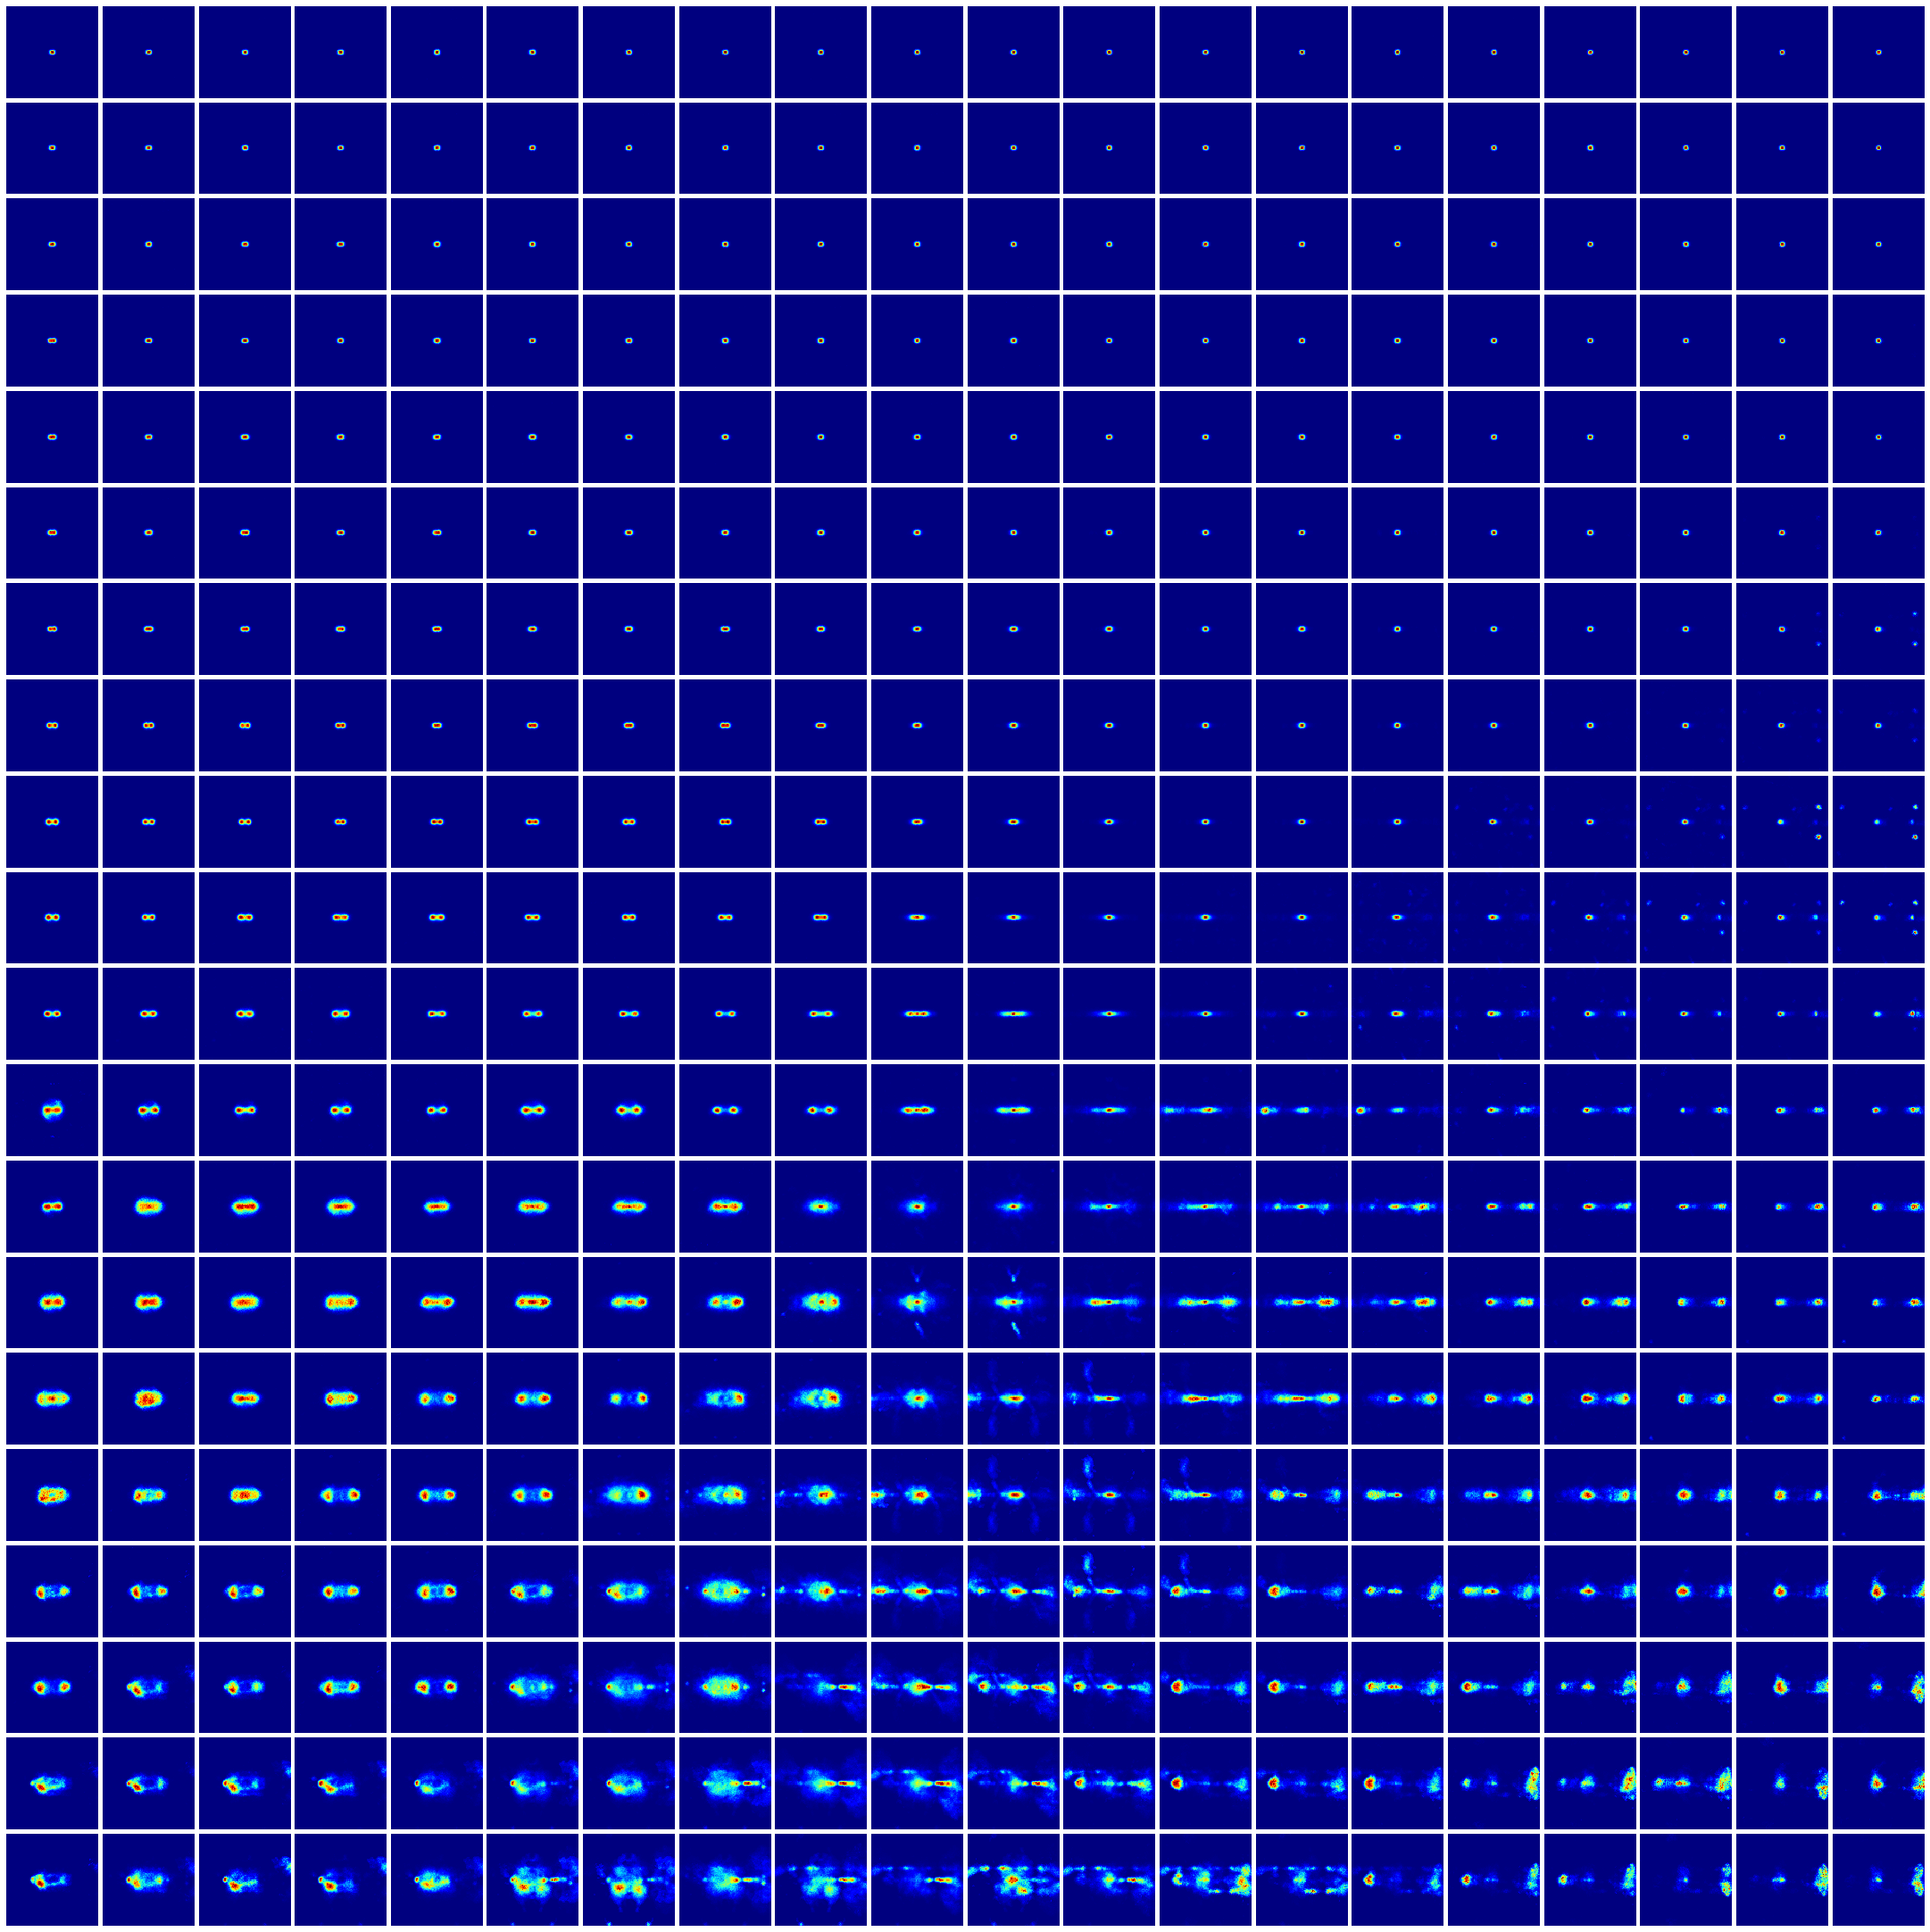

In [34]:
z = torch.randn(2).cuda()
count_x=-4.0
count_y_2=-4.0
count_y=count_y_2
x=0
y=0
plt.figure(0)
plt.figure(figsize=(30,30))
for i in range (0,20):
    for j in range (0,20):
        z[0]=count_x
        z[1]=count_y
        
        x_torch=vae.decoder(z)
        img_rec=x_torch.reshape(100,100).cpu().detach().numpy()
        ax = plt.subplot2grid((20,20), (i,j))
        ax.imshow(img_rec,cmap='jet')
        ax.set_axis_off()
        x=x+1
        count_y=count_y+0.4
    y=y+1
    count_x=count_x+0.4
    count_y=count_y_2
    
    
#sample = vae.decoder(z)
plt.tight_layout(pad = 0.5)
plt.show()

## Learning Rate Search

In [17]:
data = np.zeros((5,100)).T
columns = ['k','learning_rate','train_loss','test_loss','RAMIS']
df2 = pd.DataFrame(data, columns=columns)
count = 0
LEARNING_RATE = 0.0008
for k in range(0,100):
    pyro.clear_param_store()
    (total_epoch_loss_train,total_epoch_loss_test,incept_score)=training_loop(LEARNING_RATE,500)
    LEARNING_RATE = LEARNING_RATE + 0.000004
    df2['k'][count]=k
    df2['learning_rate'][count]=LEARNING_RATE
    df2['train_loss'][count]=total_epoch_loss_train
    df2['test_loss'][count]=total_epoch_loss_test
    df2['RAMIS'][count]=incept_score
    df2.to_csv('data_unsupervised_lrs_pa0_test_d'+str(d)+'.csv')
    count = count + 1
    print('-----------------Changing Learning Rate-------------------')

[epoch 000]  average training loss: 499.6578 testing loss: 146.2682 inception score: 1.0045
[epoch 001]  average training loss: 166.5128 testing loss: 148.0946 inception score: 1.0059
[epoch 002]  average training loss: 166.0402 testing loss: 143.2916 inception score: 1.0046
[epoch 003]  average training loss: 164.4271 testing loss: 147.7042 inception score: 1.0034
[epoch 004]  average training loss: 163.1278 testing loss: 146.5008 inception score: 1.0042
[epoch 005]  average training loss: 161.5086 testing loss: 151.5339 inception score: 1.0053
[epoch 006]  average training loss: 157.4383 testing loss: 140.7234 inception score: 1.0038
[epoch 007]  average training loss: 153.2926 testing loss: 140.4669 inception score: 1.0042
[epoch 008]  average training loss: 150.9611 testing loss: 140.9731 inception score: 1.0042
[epoch 009]  average training loss: 149.9039 testing loss: 137.7117 inception score: 1.0054
[epoch 010]  average training loss: 149.7591 testing loss: 141.5286 inception sc

[epoch 090]  average training loss: 144.3700 testing loss: 133.6793 inception score: 1.0046
[epoch 091]  average training loss: 144.7301 testing loss: 134.2731 inception score: 1.0049
[epoch 092]  average training loss: 144.2622 testing loss: 133.1156 inception score: 1.0059
[epoch 093]  average training loss: 144.3010 testing loss: 133.5335 inception score: 1.0049
[epoch 094]  average training loss: 143.9491 testing loss: 133.3461 inception score: 1.0047
[epoch 095]  average training loss: 144.3442 testing loss: 133.7092 inception score: 1.0058
[epoch 096]  average training loss: 143.9888 testing loss: 132.3939 inception score: 1.0060
[epoch 097]  average training loss: 144.0119 testing loss: 134.2130 inception score: 1.0056
[epoch 098]  average training loss: 143.7654 testing loss: 133.7827 inception score: 1.0049
[epoch 099]  average training loss: 144.1173 testing loss: 134.3323 inception score: 1.0039
[epoch 100]  average training loss: 143.8442 testing loss: 132.4079 inception sc

[epoch 180]  average training loss: 142.8002 testing loss: 132.3134 inception score: 1.0049
[epoch 181]  average training loss: 143.4103 testing loss: 131.9463 inception score: 1.0053
[epoch 182]  average training loss: 143.1852 testing loss: 132.8701 inception score: 1.0054
[epoch 183]  average training loss: 142.9656 testing loss: 132.7008 inception score: 1.0042
[epoch 184]  average training loss: 143.0538 testing loss: 132.5321 inception score: 1.0050
[epoch 185]  average training loss: 143.2202 testing loss: 133.1738 inception score: 1.0050
[epoch 186]  average training loss: 142.8048 testing loss: 133.2656 inception score: 1.0036
[epoch 187]  average training loss: 143.1416 testing loss: 132.8663 inception score: 1.0052
[epoch 188]  average training loss: 143.1705 testing loss: 132.3508 inception score: 1.0045
[epoch 189]  average training loss: 142.9176 testing loss: 131.6701 inception score: 1.0058
[epoch 190]  average training loss: 143.1276 testing loss: 131.7707 inception sc

[epoch 270]  average training loss: 142.6131 testing loss: 132.7446 inception score: 1.0071
[epoch 271]  average training loss: 142.5006 testing loss: 130.9489 inception score: 1.0069
[epoch 272]  average training loss: 142.7257 testing loss: 131.5526 inception score: 1.0047
[epoch 273]  average training loss: 142.5824 testing loss: 132.2040 inception score: 1.0043
[epoch 274]  average training loss: 142.7841 testing loss: 132.4107 inception score: 1.0059
[epoch 275]  average training loss: 142.7039 testing loss: 132.2752 inception score: 1.0087
[epoch 276]  average training loss: 142.7308 testing loss: 133.8129 inception score: 1.0070
[epoch 277]  average training loss: 142.3794 testing loss: 131.0854 inception score: 1.0060
[epoch 278]  average training loss: 142.4568 testing loss: 133.0494 inception score: 1.0067
[epoch 279]  average training loss: 142.3882 testing loss: 131.6553 inception score: 1.0057
[epoch 280]  average training loss: 142.3475 testing loss: 132.0784 inception sc

[epoch 360]  average training loss: 142.5536 testing loss: 131.9245 inception score: 1.0050
[epoch 361]  average training loss: 142.4886 testing loss: 131.1809 inception score: 1.0093
[epoch 362]  average training loss: 142.1840 testing loss: 132.2375 inception score: 1.0050
[epoch 363]  average training loss: 142.2914 testing loss: 133.3010 inception score: 1.0057
[epoch 364]  average training loss: 142.4329 testing loss: 132.5895 inception score: 1.0043
[epoch 365]  average training loss: 142.4078 testing loss: 132.6625 inception score: 1.0071
[epoch 366]  average training loss: 142.1566 testing loss: 131.7802 inception score: 1.0064
[epoch 367]  average training loss: 142.3536 testing loss: 133.5479 inception score: 1.0067
[epoch 368]  average training loss: 142.2787 testing loss: 132.4507 inception score: 1.0085
[epoch 369]  average training loss: 142.2919 testing loss: 133.4370 inception score: 1.0063
[epoch 370]  average training loss: 142.2689 testing loss: 133.9538 inception sc

[epoch 450]  average training loss: 141.9285 testing loss: 130.3826 inception score: 1.0078
[epoch 451]  average training loss: 141.8352 testing loss: 131.8389 inception score: 1.0081
[epoch 452]  average training loss: 142.0207 testing loss: 131.0999 inception score: 1.0065
[epoch 453]  average training loss: 142.2726 testing loss: 132.5850 inception score: 1.0069
[epoch 454]  average training loss: 142.0907 testing loss: 131.7650 inception score: 1.0054
[epoch 455]  average training loss: 141.9874 testing loss: 132.0062 inception score: 1.0073
[epoch 456]  average training loss: 142.0963 testing loss: 131.1944 inception score: 1.0070
[epoch 457]  average training loss: 142.3976 testing loss: 131.5533 inception score: 1.0060
[epoch 458]  average training loss: 142.2153 testing loss: 132.8551 inception score: 1.0053
[epoch 459]  average training loss: 142.3649 testing loss: 131.2341 inception score: 1.0072
[epoch 460]  average training loss: 142.1050 testing loss: 132.5871 inception sc

[epoch 039]  average training loss: 142.0336 testing loss: 130.7202 inception score: 1.0044
[epoch 040]  average training loss: 141.8780 testing loss: 132.4219 inception score: 1.0049
[epoch 041]  average training loss: 142.1182 testing loss: 131.1797 inception score: 1.0063
[epoch 042]  average training loss: 141.9615 testing loss: 131.2847 inception score: 1.0057
[epoch 043]  average training loss: 141.9685 testing loss: 132.0727 inception score: 1.0052
[epoch 044]  average training loss: 141.9576 testing loss: 131.9496 inception score: 1.0047
[epoch 045]  average training loss: 142.0148 testing loss: 131.8094 inception score: 1.0053
[epoch 046]  average training loss: 142.1761 testing loss: 132.4618 inception score: 1.0065
[epoch 047]  average training loss: 141.6974 testing loss: 133.0755 inception score: 1.0051
[epoch 048]  average training loss: 141.9842 testing loss: 131.8514 inception score: 1.0069
[epoch 049]  average training loss: 141.8486 testing loss: 131.1323 inception sc

[epoch 129]  average training loss: 141.6994 testing loss: 131.3638 inception score: 1.0062
[epoch 130]  average training loss: 141.4368 testing loss: 131.6826 inception score: 1.0048
[epoch 131]  average training loss: 141.4816 testing loss: 132.5076 inception score: 1.0060
[epoch 132]  average training loss: 141.6111 testing loss: 131.8649 inception score: 1.0048
[epoch 133]  average training loss: 141.5196 testing loss: 131.5651 inception score: 1.0044
[epoch 134]  average training loss: 141.7026 testing loss: 130.8760 inception score: 1.0041
[epoch 135]  average training loss: 141.6448 testing loss: 132.2481 inception score: 1.0050
[epoch 136]  average training loss: 141.5095 testing loss: 131.1319 inception score: 1.0046
[epoch 137]  average training loss: 141.6144 testing loss: 131.2901 inception score: 1.0051
[epoch 138]  average training loss: 141.5644 testing loss: 131.1974 inception score: 1.0056
[epoch 139]  average training loss: 141.4223 testing loss: 130.9473 inception sc

[epoch 219]  average training loss: 141.4315 testing loss: 132.1915 inception score: 1.0048
[epoch 220]  average training loss: 141.5266 testing loss: 131.6175 inception score: 1.0045
[epoch 221]  average training loss: 141.3251 testing loss: 132.1263 inception score: 1.0045
[epoch 222]  average training loss: 141.2834 testing loss: 131.0019 inception score: 1.0039
[epoch 223]  average training loss: 141.3906 testing loss: 132.2733 inception score: 1.0058
[epoch 224]  average training loss: 141.2906 testing loss: 132.2355 inception score: 1.0056
[epoch 225]  average training loss: 141.3586 testing loss: 131.5658 inception score: 1.0071
[epoch 226]  average training loss: 141.1551 testing loss: 130.6063 inception score: 1.0051
[epoch 227]  average training loss: 141.3720 testing loss: 130.4493 inception score: 1.0062
[epoch 228]  average training loss: 141.2401 testing loss: 130.7085 inception score: 1.0039
[epoch 229]  average training loss: 141.3023 testing loss: 131.7351 inception sc

[epoch 309]  average training loss: 141.2989 testing loss: 132.4578 inception score: 1.0055
[epoch 310]  average training loss: 141.1843 testing loss: 132.1369 inception score: 1.0057
[epoch 311]  average training loss: 141.0787 testing loss: 131.5226 inception score: 1.0052
[epoch 312]  average training loss: 141.0797 testing loss: 131.2077 inception score: 1.0049
[epoch 313]  average training loss: 141.0150 testing loss: 133.1146 inception score: 1.0052
[epoch 314]  average training loss: 141.0865 testing loss: 130.4799 inception score: 1.0038
[epoch 315]  average training loss: 141.1684 testing loss: 131.3869 inception score: 1.0047
[epoch 316]  average training loss: 141.0885 testing loss: 131.7565 inception score: 1.0046
[epoch 317]  average training loss: 141.1887 testing loss: 131.8506 inception score: 1.0048
[epoch 318]  average training loss: 141.1125 testing loss: 132.1803 inception score: 1.0050
[epoch 319]  average training loss: 141.2643 testing loss: 132.8068 inception sc

[epoch 399]  average training loss: 140.9560 testing loss: 130.1454 inception score: 1.0051
[epoch 400]  average training loss: 141.2187 testing loss: 131.0236 inception score: 1.0061
[epoch 401]  average training loss: 140.9490 testing loss: 131.6414 inception score: 1.0054
[epoch 402]  average training loss: 141.2598 testing loss: 130.7738 inception score: 1.0034
[epoch 403]  average training loss: 140.9152 testing loss: 131.6270 inception score: 1.0053
[epoch 404]  average training loss: 140.8831 testing loss: 130.8864 inception score: 1.0042
[epoch 405]  average training loss: 140.9373 testing loss: 131.1528 inception score: 1.0045
[epoch 406]  average training loss: 140.9923 testing loss: 131.3238 inception score: 1.0044
[epoch 407]  average training loss: 141.0911 testing loss: 131.0763 inception score: 1.0053
[epoch 408]  average training loss: 140.7875 testing loss: 131.2239 inception score: 1.0043
[epoch 409]  average training loss: 140.9877 testing loss: 131.7196 inception sc

[epoch 489]  average training loss: 140.6821 testing loss: 132.0271 inception score: 1.0051
[epoch 490]  average training loss: 140.8114 testing loss: 131.0538 inception score: 1.0050
[epoch 491]  average training loss: 140.7484 testing loss: 131.1727 inception score: 1.0036
[epoch 492]  average training loss: 140.9464 testing loss: 131.7785 inception score: 1.0044
[epoch 493]  average training loss: 140.8865 testing loss: 130.8275 inception score: 1.0043
[epoch 494]  average training loss: 140.9231 testing loss: 132.1435 inception score: 1.0034
[epoch 495]  average training loss: 140.7987 testing loss: 131.8936 inception score: 1.0040
[epoch 496]  average training loss: 140.6627 testing loss: 132.1813 inception score: 1.0044
[epoch 497]  average training loss: 140.8623 testing loss: 132.3744 inception score: 1.0041
[epoch 498]  average training loss: 140.6477 testing loss: 132.6323 inception score: 1.0043
[epoch 499]  average training loss: 140.7244 testing loss: 132.0883 inception sc

[epoch 078]  average training loss: 140.6079 testing loss: 132.6980 inception score: 1.0037
[epoch 079]  average training loss: 140.7208 testing loss: 130.6827 inception score: 1.0042
[epoch 080]  average training loss: 140.7700 testing loss: 131.0599 inception score: 1.0040
[epoch 081]  average training loss: 140.5782 testing loss: 133.1081 inception score: 1.0051
[epoch 082]  average training loss: 140.8607 testing loss: 131.9736 inception score: 1.0033
[epoch 083]  average training loss: 140.6268 testing loss: 131.3792 inception score: 1.0054
[epoch 084]  average training loss: 140.6857 testing loss: 130.4850 inception score: 1.0050
[epoch 085]  average training loss: 140.7193 testing loss: 130.9416 inception score: 1.0044
[epoch 086]  average training loss: 140.6982 testing loss: 130.6672 inception score: 1.0045
[epoch 087]  average training loss: 140.5837 testing loss: 131.0094 inception score: 1.0038
[epoch 088]  average training loss: 140.8341 testing loss: 132.9755 inception sc

[epoch 168]  average training loss: 139.7427 testing loss: 130.6254 inception score: 1.0036
[epoch 169]  average training loss: 139.4102 testing loss: 130.1199 inception score: 1.0037
[epoch 170]  average training loss: 139.3301 testing loss: 129.4296 inception score: 1.0044
[epoch 171]  average training loss: 139.2142 testing loss: 130.9570 inception score: 1.0034
[epoch 172]  average training loss: 139.2503 testing loss: 130.5413 inception score: 1.0031
[epoch 173]  average training loss: 139.3331 testing loss: 131.2083 inception score: 1.0037
[epoch 174]  average training loss: 139.1876 testing loss: 129.6183 inception score: 1.0046
[epoch 175]  average training loss: 139.3182 testing loss: 129.7941 inception score: 1.0050
[epoch 176]  average training loss: 138.8776 testing loss: 131.0277 inception score: 1.0042
[epoch 177]  average training loss: 138.9681 testing loss: 130.7607 inception score: 1.0043
[epoch 178]  average training loss: 139.1056 testing loss: 129.0729 inception sc

[epoch 258]  average training loss: 137.0364 testing loss: 129.3200 inception score: 1.0048
[epoch 259]  average training loss: 137.3223 testing loss: 128.7998 inception score: 1.0052
[epoch 260]  average training loss: 137.1581 testing loss: 128.8108 inception score: 1.0049
[epoch 261]  average training loss: 137.1314 testing loss: 128.8988 inception score: 1.0058
[epoch 262]  average training loss: 137.1945 testing loss: 128.4418 inception score: 1.0044
[epoch 263]  average training loss: 137.1341 testing loss: 129.2244 inception score: 1.0042
[epoch 264]  average training loss: 137.0687 testing loss: 130.1511 inception score: 1.0048
[epoch 265]  average training loss: 136.9263 testing loss: 129.5241 inception score: 1.0048
[epoch 266]  average training loss: 137.1853 testing loss: 129.8755 inception score: 1.0053
[epoch 267]  average training loss: 137.2634 testing loss: 128.4117 inception score: 1.0034
[epoch 268]  average training loss: 137.0135 testing loss: 129.9479 inception sc

[epoch 348]  average training loss: 136.6727 testing loss: 129.3453 inception score: 1.0056
[epoch 349]  average training loss: 136.2516 testing loss: 130.1093 inception score: 1.0060
[epoch 350]  average training loss: 136.5403 testing loss: 128.7042 inception score: 1.0048
[epoch 351]  average training loss: 136.3769 testing loss: 128.8151 inception score: 1.0060
[epoch 352]  average training loss: 136.3671 testing loss: 129.2488 inception score: 1.0050
[epoch 353]  average training loss: 136.2623 testing loss: 129.7673 inception score: 1.0057
[epoch 354]  average training loss: 136.5313 testing loss: 127.5599 inception score: 1.0052
[epoch 355]  average training loss: 136.5874 testing loss: 130.2349 inception score: 1.0061
[epoch 356]  average training loss: 136.2659 testing loss: 128.9585 inception score: 1.0059
[epoch 357]  average training loss: 136.6277 testing loss: 128.7720 inception score: 1.0056
[epoch 358]  average training loss: 136.4497 testing loss: 129.6194 inception sc

[epoch 438]  average training loss: 135.9463 testing loss: 129.0084 inception score: 1.0070
[epoch 439]  average training loss: 136.1511 testing loss: 128.4016 inception score: 1.0079
[epoch 440]  average training loss: 136.0400 testing loss: 128.4583 inception score: 1.0080
[epoch 441]  average training loss: 136.0733 testing loss: 128.0403 inception score: 1.0081
[epoch 442]  average training loss: 136.1949 testing loss: 129.0902 inception score: 1.0053
[epoch 443]  average training loss: 136.3101 testing loss: 128.9472 inception score: 1.0061
[epoch 444]  average training loss: 136.1469 testing loss: 129.2219 inception score: 1.0071
[epoch 445]  average training loss: 135.9760 testing loss: 127.8359 inception score: 1.0062
[epoch 446]  average training loss: 136.0516 testing loss: 128.8993 inception score: 1.0069
[epoch 447]  average training loss: 135.9521 testing loss: 129.2221 inception score: 1.0070
[epoch 448]  average training loss: 135.9274 testing loss: 130.3279 inception sc

[epoch 027]  average training loss: 135.9621 testing loss: 129.2940 inception score: 1.0039
[epoch 028]  average training loss: 135.7146 testing loss: 129.3827 inception score: 1.0049
[epoch 029]  average training loss: 136.0630 testing loss: 130.2104 inception score: 1.0042
[epoch 030]  average training loss: 135.6325 testing loss: 129.8735 inception score: 1.0032
[epoch 031]  average training loss: 136.0606 testing loss: 130.0574 inception score: 1.0058
[epoch 032]  average training loss: 135.7807 testing loss: 128.8500 inception score: 1.0049
[epoch 033]  average training loss: 135.8351 testing loss: 128.3102 inception score: 1.0054
[epoch 034]  average training loss: 135.9891 testing loss: 128.9580 inception score: 1.0047
[epoch 035]  average training loss: 135.9329 testing loss: 128.3523 inception score: 1.0060
[epoch 036]  average training loss: 135.7552 testing loss: 128.5904 inception score: 1.0052
[epoch 037]  average training loss: 135.8176 testing loss: 129.8868 inception sc

[epoch 117]  average training loss: 134.7225 testing loss: 128.2446 inception score: 1.0077
[epoch 118]  average training loss: 134.8464 testing loss: 128.6932 inception score: 1.0074
[epoch 119]  average training loss: 134.8404 testing loss: 128.6621 inception score: 1.0076
[epoch 120]  average training loss: 134.5441 testing loss: 127.8853 inception score: 1.0088
[epoch 121]  average training loss: 134.7026 testing loss: 128.6131 inception score: 1.0070
[epoch 122]  average training loss: 134.6105 testing loss: 127.8186 inception score: 1.0064
[epoch 123]  average training loss: 134.8475 testing loss: 127.5869 inception score: 1.0055
[epoch 124]  average training loss: 134.6207 testing loss: 128.1389 inception score: 1.0083
[epoch 125]  average training loss: 134.8793 testing loss: 128.4710 inception score: 1.0067
[epoch 126]  average training loss: 134.6816 testing loss: 129.7223 inception score: 1.0065
[epoch 127]  average training loss: 134.8904 testing loss: 127.1021 inception sc

[epoch 207]  average training loss: 133.6910 testing loss: 126.7441 inception score: 1.0152
[epoch 208]  average training loss: 133.8537 testing loss: 127.0449 inception score: 1.0181
[epoch 209]  average training loss: 133.6959 testing loss: 126.4330 inception score: 1.0136
[epoch 210]  average training loss: 133.7334 testing loss: 127.8115 inception score: 1.0125
[epoch 211]  average training loss: 133.8369 testing loss: 126.8288 inception score: 1.0147
[epoch 212]  average training loss: 133.8276 testing loss: 130.1883 inception score: 1.0131
[epoch 213]  average training loss: 133.4197 testing loss: 126.6797 inception score: 1.0151
[epoch 214]  average training loss: 133.7340 testing loss: 128.2221 inception score: 1.0192
[epoch 215]  average training loss: 133.7192 testing loss: 126.5092 inception score: 1.0141
[epoch 216]  average training loss: 133.7334 testing loss: 128.4622 inception score: 1.0181
[epoch 217]  average training loss: 133.5563 testing loss: 126.6894 inception sc

[epoch 297]  average training loss: 132.9641 testing loss: 127.9026 inception score: 1.0223
[epoch 298]  average training loss: 133.1411 testing loss: 127.7904 inception score: 1.0147
[epoch 299]  average training loss: 133.0900 testing loss: 126.3077 inception score: 1.0319
[epoch 300]  average training loss: 132.9297 testing loss: 126.8838 inception score: 1.0229
[epoch 301]  average training loss: 132.9939 testing loss: 127.1555 inception score: 1.0211
[epoch 302]  average training loss: 132.9233 testing loss: 126.4906 inception score: 1.0177
[epoch 303]  average training loss: 132.9582 testing loss: 128.2040 inception score: 1.0207
[epoch 304]  average training loss: 133.0069 testing loss: 127.3374 inception score: 1.0224
[epoch 305]  average training loss: 132.7264 testing loss: 126.8035 inception score: 1.0211
[epoch 306]  average training loss: 132.9752 testing loss: 126.3553 inception score: 1.0246
[epoch 307]  average training loss: 132.9725 testing loss: 126.7634 inception sc

[epoch 387]  average training loss: 132.5057 testing loss: 127.5544 inception score: 1.0221
[epoch 388]  average training loss: 132.5833 testing loss: 126.5514 inception score: 1.0220
[epoch 389]  average training loss: 132.6317 testing loss: 126.6339 inception score: 1.0227
[epoch 390]  average training loss: 132.4606 testing loss: 126.1621 inception score: 1.0221
[epoch 391]  average training loss: 132.6309 testing loss: 125.9761 inception score: 1.0212
[epoch 392]  average training loss: 132.6309 testing loss: 126.6853 inception score: 1.0225
[epoch 393]  average training loss: 132.5685 testing loss: 128.0916 inception score: 1.0208
[epoch 394]  average training loss: 132.4261 testing loss: 126.4437 inception score: 1.0283
[epoch 395]  average training loss: 132.2695 testing loss: 126.7188 inception score: 1.0205
[epoch 396]  average training loss: 132.5486 testing loss: 125.4132 inception score: 1.0242
[epoch 397]  average training loss: 132.6510 testing loss: 127.0041 inception sc

[epoch 477]  average training loss: 132.3820 testing loss: 125.4226 inception score: 1.0252
[epoch 478]  average training loss: 132.1183 testing loss: 126.3100 inception score: 1.0219
[epoch 479]  average training loss: 132.0650 testing loss: 126.6635 inception score: 1.0290
[epoch 480]  average training loss: 132.1662 testing loss: 127.8126 inception score: 1.0271
[epoch 481]  average training loss: 132.2527 testing loss: 127.1398 inception score: 1.0279
[epoch 482]  average training loss: 132.1140 testing loss: 126.4436 inception score: 1.0234
[epoch 483]  average training loss: 131.9296 testing loss: 126.7977 inception score: 1.0274
[epoch 484]  average training loss: 131.8826 testing loss: 125.9173 inception score: 1.0317
[epoch 485]  average training loss: 132.1934 testing loss: 128.3311 inception score: 1.0237
[epoch 486]  average training loss: 132.3500 testing loss: 126.8255 inception score: 1.0288
[epoch 487]  average training loss: 132.2011 testing loss: 127.4239 inception sc

[epoch 066]  average training loss: 132.1264 testing loss: 126.0941 inception score: 1.0269
[epoch 067]  average training loss: 131.6526 testing loss: 128.2340 inception score: 1.0266
[epoch 068]  average training loss: 131.9578 testing loss: 126.9262 inception score: 1.0221
[epoch 069]  average training loss: 132.0430 testing loss: 126.9971 inception score: 1.0244
[epoch 070]  average training loss: 131.9973 testing loss: 126.8672 inception score: 1.0266
[epoch 071]  average training loss: 131.8882 testing loss: 126.1960 inception score: 1.0264
[epoch 072]  average training loss: 131.8940 testing loss: 125.7595 inception score: 1.0279
[epoch 073]  average training loss: 131.8248 testing loss: 126.3211 inception score: 1.0218
[epoch 074]  average training loss: 131.9441 testing loss: 126.7530 inception score: 1.0262
[epoch 075]  average training loss: 131.4465 testing loss: 126.8979 inception score: 1.0254
[epoch 076]  average training loss: 131.8438 testing loss: 127.2532 inception sc

[epoch 156]  average training loss: 130.9147 testing loss: 127.3347 inception score: 1.0262
[epoch 157]  average training loss: 131.1915 testing loss: 126.8626 inception score: 1.0277
[epoch 158]  average training loss: 131.1635 testing loss: 127.3259 inception score: 1.0294
[epoch 159]  average training loss: 131.2369 testing loss: 126.9579 inception score: 1.0297
[epoch 160]  average training loss: 131.2652 testing loss: 127.2982 inception score: 1.0257
[epoch 161]  average training loss: 131.4080 testing loss: 127.5352 inception score: 1.0225
[epoch 162]  average training loss: 131.0434 testing loss: 127.2822 inception score: 1.0225
[epoch 163]  average training loss: 130.9040 testing loss: 126.5467 inception score: 1.0259
[epoch 164]  average training loss: 131.2997 testing loss: 126.3156 inception score: 1.0247
[epoch 165]  average training loss: 130.9860 testing loss: 128.0418 inception score: 1.0275
[epoch 166]  average training loss: 131.2957 testing loss: 126.5741 inception sc

[epoch 246]  average training loss: 130.8368 testing loss: 126.1612 inception score: 1.0221
[epoch 247]  average training loss: 130.7021 testing loss: 127.4876 inception score: 1.0255
[epoch 248]  average training loss: 130.8482 testing loss: 127.6865 inception score: 1.0263
[epoch 249]  average training loss: 130.8571 testing loss: 127.6864 inception score: 1.0284
[epoch 250]  average training loss: 130.9276 testing loss: 126.7141 inception score: 1.0183
[epoch 251]  average training loss: 130.6175 testing loss: 126.3591 inception score: 1.0250
[epoch 252]  average training loss: 130.7274 testing loss: 127.6647 inception score: 1.0285
[epoch 253]  average training loss: 130.6781 testing loss: 127.8876 inception score: 1.0274
[epoch 254]  average training loss: 130.9279 testing loss: 126.2196 inception score: 1.0260
[epoch 255]  average training loss: 130.5949 testing loss: 126.8830 inception score: 1.0252
[epoch 256]  average training loss: 130.5648 testing loss: 127.7388 inception sc

[epoch 336]  average training loss: 130.6261 testing loss: 126.9018 inception score: 1.0232
[epoch 337]  average training loss: 130.5631 testing loss: 126.3168 inception score: 1.0247
[epoch 338]  average training loss: 130.4269 testing loss: 127.2892 inception score: 1.0231
[epoch 339]  average training loss: 130.5763 testing loss: 127.8456 inception score: 1.0234
[epoch 340]  average training loss: 130.7720 testing loss: 127.3507 inception score: 1.0236
[epoch 341]  average training loss: 130.5014 testing loss: 126.0869 inception score: 1.0225
[epoch 342]  average training loss: 130.6721 testing loss: 126.9731 inception score: 1.0258
[epoch 343]  average training loss: 130.4504 testing loss: 126.6842 inception score: 1.0249
[epoch 344]  average training loss: 130.5557 testing loss: 127.6977 inception score: 1.0284
[epoch 345]  average training loss: 130.4800 testing loss: 126.8979 inception score: 1.0241
[epoch 346]  average training loss: 130.2403 testing loss: 126.4932 inception sc

[epoch 426]  average training loss: 130.0637 testing loss: 127.6898 inception score: 1.0256
[epoch 427]  average training loss: 130.4011 testing loss: 128.0123 inception score: 1.0241
[epoch 428]  average training loss: 130.3195 testing loss: 128.0178 inception score: 1.0226
[epoch 429]  average training loss: 130.2271 testing loss: 126.6770 inception score: 1.0265
[epoch 430]  average training loss: 130.2401 testing loss: 126.1384 inception score: 1.0230
[epoch 431]  average training loss: 130.3555 testing loss: 126.6854 inception score: 1.0269
[epoch 432]  average training loss: 130.1290 testing loss: 127.8572 inception score: 1.0245
[epoch 433]  average training loss: 130.0462 testing loss: 125.6265 inception score: 1.0261
[epoch 434]  average training loss: 130.3839 testing loss: 127.1609 inception score: 1.0234
[epoch 435]  average training loss: 130.2266 testing loss: 125.8908 inception score: 1.0219
[epoch 436]  average training loss: 130.3362 testing loss: 127.4641 inception sc

[epoch 015]  average training loss: 130.4081 testing loss: 127.2684 inception score: 1.0156
[epoch 016]  average training loss: 131.0057 testing loss: 126.4317 inception score: 1.0176
[epoch 017]  average training loss: 130.7244 testing loss: 127.0158 inception score: 1.0213
[epoch 018]  average training loss: 130.5631 testing loss: 127.5050 inception score: 1.0209
[epoch 019]  average training loss: 130.4245 testing loss: 127.6298 inception score: 1.0236
[epoch 020]  average training loss: 130.3413 testing loss: 126.2040 inception score: 1.0192
[epoch 021]  average training loss: 130.7735 testing loss: 126.1055 inception score: 1.0202
[epoch 022]  average training loss: 130.3712 testing loss: 126.5066 inception score: 1.0223
[epoch 023]  average training loss: 130.4945 testing loss: 126.2946 inception score: 1.0232
[epoch 024]  average training loss: 130.3851 testing loss: 127.8841 inception score: 1.0207
[epoch 025]  average training loss: 130.5830 testing loss: 127.1110 inception sc

[epoch 105]  average training loss: 129.3931 testing loss: 127.0871 inception score: 1.0244
[epoch 106]  average training loss: 129.6534 testing loss: 127.7023 inception score: 1.0211
[epoch 107]  average training loss: 129.5035 testing loss: 127.2014 inception score: 1.0222
[epoch 108]  average training loss: 129.5189 testing loss: 126.3941 inception score: 1.0263
[epoch 109]  average training loss: 129.5783 testing loss: 127.1878 inception score: 1.0204
[epoch 110]  average training loss: 129.4666 testing loss: 126.7042 inception score: 1.0209
[epoch 111]  average training loss: 129.4715 testing loss: 126.3736 inception score: 1.0185
[epoch 112]  average training loss: 129.5968 testing loss: 126.3951 inception score: 1.0233
[epoch 113]  average training loss: 129.2348 testing loss: 128.9577 inception score: 1.0224
[epoch 114]  average training loss: 129.4039 testing loss: 127.4067 inception score: 1.0257
[epoch 115]  average training loss: 129.4105 testing loss: 126.8914 inception sc

[epoch 195]  average training loss: 129.0410 testing loss: 127.4630 inception score: 1.0197
[epoch 196]  average training loss: 129.1144 testing loss: 127.4815 inception score: 1.0201
[epoch 197]  average training loss: 129.2226 testing loss: 127.9419 inception score: 1.0257
[epoch 198]  average training loss: 129.0615 testing loss: 127.1769 inception score: 1.0234
[epoch 199]  average training loss: 129.3453 testing loss: 127.7033 inception score: 1.0216
[epoch 200]  average training loss: 129.3213 testing loss: 128.2192 inception score: 1.0198
[epoch 201]  average training loss: 129.0748 testing loss: 127.7596 inception score: 1.0191
[epoch 202]  average training loss: 129.2863 testing loss: 128.2650 inception score: 1.0275
[epoch 203]  average training loss: 129.0868 testing loss: 126.1674 inception score: 1.0234
[epoch 204]  average training loss: 129.0529 testing loss: 127.8011 inception score: 1.0283
[epoch 205]  average training loss: 129.3104 testing loss: 128.4507 inception sc

[epoch 285]  average training loss: 129.0053 testing loss: 127.0603 inception score: 1.0202
[epoch 286]  average training loss: 128.6665 testing loss: 127.3715 inception score: 1.0222
[epoch 287]  average training loss: 128.6256 testing loss: 127.7099 inception score: 1.0206
[epoch 288]  average training loss: 129.1665 testing loss: 127.8863 inception score: 1.0215
[epoch 289]  average training loss: 128.7777 testing loss: 127.0420 inception score: 1.0237
[epoch 290]  average training loss: 128.9356 testing loss: 129.8473 inception score: 1.0193
[epoch 291]  average training loss: 128.7289 testing loss: 128.6365 inception score: 1.0221
[epoch 292]  average training loss: 128.9226 testing loss: 126.7108 inception score: 1.0231
[epoch 293]  average training loss: 129.1068 testing loss: 126.4899 inception score: 1.0217
[epoch 294]  average training loss: 128.9042 testing loss: 128.0182 inception score: 1.0176
[epoch 295]  average training loss: 128.8124 testing loss: 127.9250 inception sc

[epoch 375]  average training loss: 128.4640 testing loss: 127.0775 inception score: 1.0211
[epoch 376]  average training loss: 128.7740 testing loss: 128.8543 inception score: 1.0205
[epoch 377]  average training loss: 128.3582 testing loss: 126.0475 inception score: 1.0236
[epoch 378]  average training loss: 128.4765 testing loss: 127.9009 inception score: 1.0202
[epoch 379]  average training loss: 128.6062 testing loss: 126.7197 inception score: 1.0224
[epoch 380]  average training loss: 128.7089 testing loss: 128.1212 inception score: 1.0169
[epoch 381]  average training loss: 128.3932 testing loss: 129.5544 inception score: 1.0211
[epoch 382]  average training loss: 128.3540 testing loss: 127.2856 inception score: 1.0233
[epoch 383]  average training loss: 128.6672 testing loss: 128.2240 inception score: 1.0204
[epoch 384]  average training loss: 128.4514 testing loss: 127.1238 inception score: 1.0231
[epoch 385]  average training loss: 128.3153 testing loss: 128.6404 inception sc

[epoch 465]  average training loss: 128.2473 testing loss: 128.6161 inception score: 1.0260
[epoch 466]  average training loss: 128.1818 testing loss: 129.0929 inception score: 1.0188
[epoch 467]  average training loss: 128.3593 testing loss: 128.3127 inception score: 1.0224
[epoch 468]  average training loss: 128.2819 testing loss: 128.7174 inception score: 1.0183
[epoch 469]  average training loss: 128.3677 testing loss: 127.4747 inception score: 1.0183
[epoch 470]  average training loss: 128.7645 testing loss: 128.2245 inception score: 1.0198
[epoch 471]  average training loss: 128.4606 testing loss: 127.6656 inception score: 1.0270
[epoch 472]  average training loss: 128.3992 testing loss: 127.3197 inception score: 1.0207
[epoch 473]  average training loss: 128.3466 testing loss: 128.1319 inception score: 1.0198
[epoch 474]  average training loss: 128.2622 testing loss: 129.2458 inception score: 1.0229
[epoch 475]  average training loss: 128.3115 testing loss: 126.1191 inception sc

[epoch 054]  average training loss: 128.3377 testing loss: 128.3324 inception score: 1.0179
[epoch 055]  average training loss: 127.8821 testing loss: 126.0533 inception score: 1.0241
[epoch 056]  average training loss: 128.1961 testing loss: 128.0160 inception score: 1.0186
[epoch 057]  average training loss: 128.3574 testing loss: 127.8779 inception score: 1.0195
[epoch 058]  average training loss: 128.3760 testing loss: 127.7988 inception score: 1.0202
[epoch 059]  average training loss: 128.0372 testing loss: 128.0034 inception score: 1.0178
[epoch 060]  average training loss: 128.0304 testing loss: 126.3837 inception score: 1.0207
[epoch 061]  average training loss: 128.1343 testing loss: 126.7483 inception score: 1.0205
[epoch 062]  average training loss: 128.0252 testing loss: 128.2707 inception score: 1.0174
[epoch 063]  average training loss: 128.6316 testing loss: 126.2678 inception score: 1.0194
[epoch 064]  average training loss: 127.9914 testing loss: 128.1922 inception sc

[epoch 144]  average training loss: 127.2240 testing loss: 126.8333 inception score: 1.0238
[epoch 145]  average training loss: 127.0871 testing loss: 127.2223 inception score: 1.0220
[epoch 146]  average training loss: 127.3567 testing loss: 127.4499 inception score: 1.0297
[epoch 147]  average training loss: 127.1613 testing loss: 126.9847 inception score: 1.0237
[epoch 148]  average training loss: 127.1686 testing loss: 127.6772 inception score: 1.0177
[epoch 149]  average training loss: 126.9311 testing loss: 128.0685 inception score: 1.0200
[epoch 150]  average training loss: 127.2518 testing loss: 127.3644 inception score: 1.0193
[epoch 151]  average training loss: 127.2121 testing loss: 128.0350 inception score: 1.0213
[epoch 152]  average training loss: 126.9848 testing loss: 126.2232 inception score: 1.0222
[epoch 153]  average training loss: 126.8328 testing loss: 127.8982 inception score: 1.0191
[epoch 154]  average training loss: 127.1095 testing loss: 127.2130 inception sc

[epoch 234]  average training loss: 126.5287 testing loss: 126.7938 inception score: 1.0219
[epoch 235]  average training loss: 126.9403 testing loss: 125.8475 inception score: 1.0201
[epoch 236]  average training loss: 126.5655 testing loss: 130.5520 inception score: 1.0227
[epoch 237]  average training loss: 126.5044 testing loss: 125.6110 inception score: 1.0318
[epoch 238]  average training loss: 126.3138 testing loss: 126.3132 inception score: 1.0192
[epoch 239]  average training loss: 126.5820 testing loss: 126.7559 inception score: 1.0253
[epoch 240]  average training loss: 126.5887 testing loss: 128.4289 inception score: 1.0261
[epoch 241]  average training loss: 126.5946 testing loss: 127.0493 inception score: 1.0196
[epoch 242]  average training loss: 126.4615 testing loss: 125.6937 inception score: 1.0249
[epoch 243]  average training loss: 126.4134 testing loss: 127.4943 inception score: 1.0223
[epoch 244]  average training loss: 126.8907 testing loss: 127.3841 inception sc

[epoch 324]  average training loss: 126.1907 testing loss: 126.2019 inception score: 1.0195
[epoch 325]  average training loss: 126.2590 testing loss: 125.6314 inception score: 1.0184
[epoch 326]  average training loss: 126.4297 testing loss: 127.2291 inception score: 1.0175
[epoch 327]  average training loss: 126.4048 testing loss: 128.0437 inception score: 1.0205
[epoch 328]  average training loss: 125.9710 testing loss: 129.5418 inception score: 1.0239
[epoch 329]  average training loss: 125.9261 testing loss: 127.3186 inception score: 1.0239
[epoch 330]  average training loss: 125.9181 testing loss: 126.7318 inception score: 1.0164
[epoch 331]  average training loss: 125.9505 testing loss: 127.0783 inception score: 1.0233
[epoch 332]  average training loss: 126.2947 testing loss: 126.8178 inception score: 1.0216
[epoch 333]  average training loss: 126.3292 testing loss: 126.1226 inception score: 1.0175
[epoch 334]  average training loss: 126.1792 testing loss: 128.0198 inception sc

[epoch 414]  average training loss: 125.5514 testing loss: 127.3729 inception score: 1.0199
[epoch 415]  average training loss: 125.8260 testing loss: 127.7801 inception score: 1.0186
[epoch 416]  average training loss: 126.0082 testing loss: 124.6009 inception score: 1.0244
[epoch 417]  average training loss: 125.6450 testing loss: 125.9024 inception score: 1.0186
[epoch 418]  average training loss: 126.1062 testing loss: 125.8682 inception score: 1.0177
[epoch 419]  average training loss: 125.6116 testing loss: 127.0008 inception score: 1.0200
[epoch 420]  average training loss: 125.7689 testing loss: 126.0517 inception score: 1.0243
[epoch 421]  average training loss: 125.5385 testing loss: 126.5087 inception score: 1.0177
[epoch 422]  average training loss: 125.6570 testing loss: 126.1437 inception score: 1.0210
[epoch 423]  average training loss: 125.8972 testing loss: 126.8990 inception score: 1.0212
[epoch 424]  average training loss: 125.7322 testing loss: 126.5295 inception sc

[epoch 003]  average training loss: 127.1963 testing loss: 127.3937 inception score: 1.0216
[epoch 004]  average training loss: 126.5321 testing loss: 127.7091 inception score: 1.0206
[epoch 005]  average training loss: 126.6523 testing loss: 125.5822 inception score: 1.0230
[epoch 006]  average training loss: 127.2054 testing loss: 127.4756 inception score: 1.0165
[epoch 007]  average training loss: 126.4499 testing loss: 127.0116 inception score: 1.0204
[epoch 008]  average training loss: 126.5394 testing loss: 127.6104 inception score: 1.0225
[epoch 009]  average training loss: 126.2177 testing loss: 125.4527 inception score: 1.0226
[epoch 010]  average training loss: 126.9324 testing loss: 126.9573 inception score: 1.0169
[epoch 011]  average training loss: 125.8569 testing loss: 127.7624 inception score: 1.0235
[epoch 012]  average training loss: 126.5982 testing loss: 128.5056 inception score: 1.0208
[epoch 013]  average training loss: 126.4788 testing loss: 125.6620 inception sc

[epoch 093]  average training loss: 124.5101 testing loss: 125.8959 inception score: 1.0198
[epoch 094]  average training loss: 124.5232 testing loss: 128.0578 inception score: 1.0122
[epoch 095]  average training loss: 124.6332 testing loss: 127.0047 inception score: 1.0176
[epoch 096]  average training loss: 124.3997 testing loss: 126.7196 inception score: 1.0147
[epoch 097]  average training loss: 124.6961 testing loss: 126.4085 inception score: 1.0150
[epoch 098]  average training loss: 124.6230 testing loss: 128.0706 inception score: 1.0165
[epoch 099]  average training loss: 124.3845 testing loss: 126.5952 inception score: 1.0196
[epoch 100]  average training loss: 124.7117 testing loss: 127.9842 inception score: 1.0194
[epoch 101]  average training loss: 124.4958 testing loss: 127.4081 inception score: 1.0167
[epoch 102]  average training loss: 124.3600 testing loss: 127.5534 inception score: 1.0187
[epoch 103]  average training loss: 124.5388 testing loss: 126.7483 inception sc

[epoch 183]  average training loss: 123.7166 testing loss: 126.3162 inception score: 1.0178
[epoch 184]  average training loss: 123.9231 testing loss: 126.7937 inception score: 1.0147
[epoch 185]  average training loss: 124.0902 testing loss: 126.0654 inception score: 1.0212
[epoch 186]  average training loss: 123.7638 testing loss: 125.9776 inception score: 1.0138
[epoch 187]  average training loss: 123.7958 testing loss: 127.0148 inception score: 1.0170
[epoch 188]  average training loss: 123.6716 testing loss: 126.2443 inception score: 1.0151
[epoch 189]  average training loss: 123.6707 testing loss: 126.8564 inception score: 1.0156
[epoch 190]  average training loss: 123.6407 testing loss: 124.1599 inception score: 1.0197
[epoch 191]  average training loss: 123.5753 testing loss: 125.9405 inception score: 1.0159
[epoch 192]  average training loss: 123.5686 testing loss: 125.9066 inception score: 1.0277
[epoch 193]  average training loss: 123.6773 testing loss: 127.3332 inception sc

[epoch 273]  average training loss: 123.2181 testing loss: 126.4892 inception score: 1.0214
[epoch 274]  average training loss: 123.2430 testing loss: 125.7264 inception score: 1.0192
[epoch 275]  average training loss: 123.3627 testing loss: 126.9539 inception score: 1.0163
[epoch 276]  average training loss: 123.1418 testing loss: 129.1394 inception score: 1.0242
[epoch 277]  average training loss: 123.1540 testing loss: 127.9608 inception score: 1.0254
[epoch 278]  average training loss: 123.1178 testing loss: 127.3684 inception score: 1.0160
[epoch 279]  average training loss: 123.4272 testing loss: 127.4987 inception score: 1.0236
[epoch 280]  average training loss: 123.3461 testing loss: 127.2812 inception score: 1.0253
[epoch 281]  average training loss: 123.1888 testing loss: 126.5392 inception score: 1.0315
[epoch 282]  average training loss: 123.4981 testing loss: 127.3779 inception score: 1.0179
[epoch 283]  average training loss: 123.0370 testing loss: 126.3136 inception sc

[epoch 363]  average training loss: 122.7001 testing loss: 125.1784 inception score: 1.0186
[epoch 364]  average training loss: 122.7386 testing loss: 126.8834 inception score: 1.0307
[epoch 365]  average training loss: 122.3087 testing loss: 127.1893 inception score: 1.0207
[epoch 366]  average training loss: 122.6117 testing loss: 125.9918 inception score: 1.0340
[epoch 367]  average training loss: 123.2129 testing loss: 125.5661 inception score: 1.0269
[epoch 368]  average training loss: 122.8240 testing loss: 125.3968 inception score: 1.0195
[epoch 369]  average training loss: 122.9895 testing loss: 127.7078 inception score: 1.0247
[epoch 370]  average training loss: 122.9632 testing loss: 126.0050 inception score: 1.0305
[epoch 371]  average training loss: 123.0095 testing loss: 125.3139 inception score: 1.0294
[epoch 372]  average training loss: 122.8342 testing loss: 126.3569 inception score: 1.0382
[epoch 373]  average training loss: 122.8169 testing loss: 125.1235 inception sc

[epoch 453]  average training loss: 122.6459 testing loss: 124.3641 inception score: 1.0472
[epoch 454]  average training loss: 122.6489 testing loss: 126.9303 inception score: 1.0348
[epoch 455]  average training loss: 122.2775 testing loss: 126.3826 inception score: 1.0426
[epoch 456]  average training loss: 122.4853 testing loss: 124.5236 inception score: 1.0247
[epoch 457]  average training loss: 122.2334 testing loss: 126.2871 inception score: 1.0362
[epoch 458]  average training loss: 122.4866 testing loss: 126.2909 inception score: 1.0212
[epoch 459]  average training loss: 122.5374 testing loss: 125.1537 inception score: 1.0267
[epoch 460]  average training loss: 122.5388 testing loss: 127.0731 inception score: 1.0363
[epoch 461]  average training loss: 122.7046 testing loss: 125.7107 inception score: 1.0314
[epoch 462]  average training loss: 122.3899 testing loss: 124.2541 inception score: 1.0369
[epoch 463]  average training loss: 122.3605 testing loss: 125.3084 inception sc

[epoch 042]  average training loss: 122.7003 testing loss: 126.0292 inception score: 1.0468
[epoch 043]  average training loss: 122.4300 testing loss: 128.6371 inception score: 1.0621
[epoch 044]  average training loss: 122.4037 testing loss: 125.8062 inception score: 1.0707
[epoch 045]  average training loss: 122.2291 testing loss: 126.4983 inception score: 1.0409
[epoch 046]  average training loss: 122.4464 testing loss: 127.1835 inception score: 1.0667
[epoch 047]  average training loss: 122.5801 testing loss: 127.0290 inception score: 1.0505
[epoch 048]  average training loss: 122.3006 testing loss: 125.3032 inception score: 1.0537
[epoch 049]  average training loss: 122.3243 testing loss: 125.1472 inception score: 1.0781
[epoch 050]  average training loss: 122.6558 testing loss: 125.0230 inception score: 1.0414
[epoch 051]  average training loss: 122.3079 testing loss: 127.0648 inception score: 1.0517
[epoch 052]  average training loss: 122.3157 testing loss: 126.8098 inception sc

[epoch 132]  average training loss: 121.4959 testing loss: 128.2362 inception score: 1.0445
[epoch 133]  average training loss: 121.6531 testing loss: 126.0847 inception score: 1.0480
[epoch 134]  average training loss: 121.4584 testing loss: 125.0340 inception score: 1.0785
[epoch 135]  average training loss: 121.5216 testing loss: 125.6098 inception score: 1.0899
[epoch 136]  average training loss: 121.4814 testing loss: 127.9121 inception score: 1.0739
[epoch 137]  average training loss: 121.5538 testing loss: 127.7057 inception score: 1.0677
[epoch 138]  average training loss: 121.4737 testing loss: 124.8741 inception score: 1.0708
[epoch 139]  average training loss: 121.6146 testing loss: 126.9193 inception score: 1.0838
[epoch 140]  average training loss: 121.5732 testing loss: 126.1558 inception score: 1.0894
[epoch 141]  average training loss: 121.7226 testing loss: 127.2125 inception score: 1.0731
[epoch 142]  average training loss: 121.7855 testing loss: 127.9327 inception sc

[epoch 222]  average training loss: 121.4470 testing loss: 126.4095 inception score: 1.0648
[epoch 223]  average training loss: 120.7303 testing loss: 126.5316 inception score: 1.0988
[epoch 224]  average training loss: 120.8030 testing loss: 127.5258 inception score: 1.0806
[epoch 225]  average training loss: 121.0010 testing loss: 126.8664 inception score: 1.0997
[epoch 226]  average training loss: 121.0848 testing loss: 128.3527 inception score: 1.0818
[epoch 227]  average training loss: 120.9215 testing loss: 126.2414 inception score: 1.1044
[epoch 228]  average training loss: 121.0287 testing loss: 126.2772 inception score: 1.1070
[epoch 229]  average training loss: 121.2920 testing loss: 127.4785 inception score: 1.0748
[epoch 230]  average training loss: 121.0967 testing loss: 126.1288 inception score: 1.1029
[epoch 231]  average training loss: 120.8874 testing loss: 126.4452 inception score: 1.0705
[epoch 232]  average training loss: 120.9069 testing loss: 129.0330 inception sc

[epoch 312]  average training loss: 120.6301 testing loss: 126.9274 inception score: 1.1041
[epoch 313]  average training loss: 120.5654 testing loss: 126.9085 inception score: 1.1181
[epoch 314]  average training loss: 120.6610 testing loss: 127.9191 inception score: 1.1275
[epoch 315]  average training loss: 120.3669 testing loss: 127.7153 inception score: 1.0733
[epoch 316]  average training loss: 120.4967 testing loss: 125.1303 inception score: 1.0801
[epoch 317]  average training loss: 120.6862 testing loss: 127.9650 inception score: 1.1043
[epoch 318]  average training loss: 120.9252 testing loss: 127.3822 inception score: 1.1076
[epoch 319]  average training loss: 120.6954 testing loss: 127.5746 inception score: 1.0801
[epoch 320]  average training loss: 120.3726 testing loss: 125.4924 inception score: 1.1146
[epoch 321]  average training loss: 120.6474 testing loss: 126.7507 inception score: 1.0840
[epoch 322]  average training loss: 120.5175 testing loss: 128.1007 inception sc

[epoch 402]  average training loss: 120.1105 testing loss: 125.1163 inception score: 1.1438
[epoch 403]  average training loss: 120.2953 testing loss: 127.7569 inception score: 1.0848
[epoch 404]  average training loss: 120.3001 testing loss: 126.0907 inception score: 1.1169
[epoch 405]  average training loss: 120.0597 testing loss: 125.9900 inception score: 1.0955
[epoch 406]  average training loss: 120.1458 testing loss: 126.1510 inception score: 1.1054
[epoch 407]  average training loss: 120.2343 testing loss: 128.9247 inception score: 1.0968
[epoch 408]  average training loss: 120.2522 testing loss: 125.5822 inception score: 1.0775
[epoch 409]  average training loss: 120.3637 testing loss: 126.5506 inception score: 1.0897
[epoch 410]  average training loss: 120.3174 testing loss: 125.8646 inception score: 1.1169
[epoch 411]  average training loss: 119.9901 testing loss: 126.6811 inception score: 1.1267
[epoch 412]  average training loss: 120.2955 testing loss: 126.0219 inception sc

[epoch 492]  average training loss: 120.4078 testing loss: 126.9408 inception score: 1.0906
[epoch 493]  average training loss: 119.9535 testing loss: 127.3652 inception score: 1.1342
[epoch 494]  average training loss: 120.2046 testing loss: 128.3744 inception score: 1.1204
[epoch 495]  average training loss: 119.8764 testing loss: 126.0905 inception score: 1.0987
[epoch 496]  average training loss: 119.7269 testing loss: 128.1291 inception score: 1.1137
[epoch 497]  average training loss: 119.9738 testing loss: 126.6288 inception score: 1.1220
[epoch 498]  average training loss: 119.7746 testing loss: 127.3639 inception score: 1.1212
[epoch 499]  average training loss: 119.6952 testing loss: 128.6347 inception score: 1.0709
-----------------Changing Learning Rate-------------------
[epoch 000]  average training loss: 138.9513 testing loss: 128.9949 inception score: 1.0174
[epoch 001]  average training loss: 124.7215 testing loss: 126.1651 inception score: 1.0697
[epoch 002]  average 

[epoch 081]  average training loss: 119.5729 testing loss: 127.5936 inception score: 1.1560
[epoch 082]  average training loss: 119.6589 testing loss: 127.2961 inception score: 1.1513
[epoch 083]  average training loss: 119.6048 testing loss: 125.6040 inception score: 1.0936
[epoch 084]  average training loss: 119.6465 testing loss: 126.7956 inception score: 1.0969
[epoch 085]  average training loss: 119.6305 testing loss: 126.9818 inception score: 1.1540
[epoch 086]  average training loss: 119.5937 testing loss: 126.8255 inception score: 1.1552
[epoch 087]  average training loss: 119.5028 testing loss: 124.4380 inception score: 1.1415
[epoch 088]  average training loss: 119.4226 testing loss: 126.4878 inception score: 1.1066
[epoch 089]  average training loss: 119.6004 testing loss: 125.3019 inception score: 1.0972
[epoch 090]  average training loss: 119.5913 testing loss: 127.8709 inception score: 1.0973
[epoch 091]  average training loss: 119.4762 testing loss: 125.6612 inception sc

[epoch 171]  average training loss: 119.3585 testing loss: 127.1351 inception score: 1.1524
[epoch 172]  average training loss: 119.3476 testing loss: 125.7715 inception score: 1.1358
[epoch 173]  average training loss: 118.9338 testing loss: 127.8136 inception score: 1.1159
[epoch 174]  average training loss: 118.9749 testing loss: 128.8022 inception score: 1.1642
[epoch 175]  average training loss: 118.8418 testing loss: 127.6459 inception score: 1.1535
[epoch 176]  average training loss: 119.0118 testing loss: 125.7808 inception score: 1.1140
[epoch 177]  average training loss: 119.1782 testing loss: 128.3353 inception score: 1.1257
[epoch 178]  average training loss: 119.1293 testing loss: 127.6285 inception score: 1.1324
[epoch 179]  average training loss: 119.3297 testing loss: 127.6335 inception score: 1.1662
[epoch 180]  average training loss: 118.8492 testing loss: 127.1364 inception score: 1.1198
[epoch 181]  average training loss: 119.0029 testing loss: 126.2366 inception sc

[epoch 261]  average training loss: 118.2647 testing loss: 126.8443 inception score: 1.1131
[epoch 262]  average training loss: 118.6350 testing loss: 124.4047 inception score: 1.1865
[epoch 263]  average training loss: 118.6655 testing loss: 125.9862 inception score: 1.1504
[epoch 264]  average training loss: 118.2474 testing loss: 125.9405 inception score: 1.1753
[epoch 265]  average training loss: 118.3225 testing loss: 127.2545 inception score: 1.1316
[epoch 266]  average training loss: 118.8458 testing loss: 125.2428 inception score: 1.1253
[epoch 267]  average training loss: 118.4040 testing loss: 125.3647 inception score: 1.1482
[epoch 268]  average training loss: 118.7710 testing loss: 125.7787 inception score: 1.1600
[epoch 269]  average training loss: 118.5634 testing loss: 127.5789 inception score: 1.1654
[epoch 270]  average training loss: 118.3150 testing loss: 126.1806 inception score: 1.1447
[epoch 271]  average training loss: 118.6816 testing loss: 126.0581 inception sc

[epoch 351]  average training loss: 118.3917 testing loss: 126.9811 inception score: 1.1804
[epoch 352]  average training loss: 118.7221 testing loss: 127.1705 inception score: 1.1706
[epoch 353]  average training loss: 118.0691 testing loss: 125.4137 inception score: 1.1679
[epoch 354]  average training loss: 118.2091 testing loss: 124.6871 inception score: 1.1711
[epoch 355]  average training loss: 118.3200 testing loss: 126.1917 inception score: 1.1889
[epoch 356]  average training loss: 118.1107 testing loss: 124.4512 inception score: 1.1465
[epoch 357]  average training loss: 118.4517 testing loss: 126.0975 inception score: 1.1702
[epoch 358]  average training loss: 118.6878 testing loss: 127.3954 inception score: 1.1445
[epoch 359]  average training loss: 118.2001 testing loss: 125.8245 inception score: 1.1253
[epoch 360]  average training loss: 118.6804 testing loss: 125.6354 inception score: 1.1620
[epoch 361]  average training loss: 118.4138 testing loss: 124.6556 inception sc

[epoch 441]  average training loss: 118.0947 testing loss: 126.6286 inception score: 1.1603
[epoch 442]  average training loss: 117.8796 testing loss: 125.4475 inception score: 1.1180
[epoch 443]  average training loss: 118.2687 testing loss: 127.4643 inception score: 1.1699
[epoch 444]  average training loss: 117.8110 testing loss: 124.5102 inception score: 1.1181
[epoch 445]  average training loss: 117.8264 testing loss: 127.6618 inception score: 1.1717
[epoch 446]  average training loss: 117.6777 testing loss: 128.1105 inception score: 1.1478
[epoch 447]  average training loss: 117.8413 testing loss: 127.0528 inception score: 1.2200
[epoch 448]  average training loss: 118.1488 testing loss: 125.8625 inception score: 1.1808
[epoch 449]  average training loss: 117.8309 testing loss: 126.1349 inception score: 1.1639
[epoch 450]  average training loss: 118.0423 testing loss: 126.9986 inception score: 1.1830
[epoch 451]  average training loss: 117.7675 testing loss: 125.3892 inception sc

[epoch 030]  average training loss: 118.5519 testing loss: 125.0868 inception score: 1.1703
[epoch 031]  average training loss: 118.3543 testing loss: 126.0881 inception score: 1.1800
[epoch 032]  average training loss: 118.4352 testing loss: 125.5784 inception score: 1.1925
[epoch 033]  average training loss: 118.4457 testing loss: 123.8860 inception score: 1.1392
[epoch 034]  average training loss: 118.0319 testing loss: 128.9757 inception score: 1.1725
[epoch 035]  average training loss: 118.0678 testing loss: 125.1481 inception score: 1.1769
[epoch 036]  average training loss: 118.2331 testing loss: 128.6838 inception score: 1.1711
[epoch 037]  average training loss: 118.1432 testing loss: 127.4435 inception score: 1.1095
[epoch 038]  average training loss: 118.2970 testing loss: 124.9919 inception score: 1.1553
[epoch 039]  average training loss: 118.0899 testing loss: 124.0384 inception score: 1.1677
[epoch 040]  average training loss: 118.1387 testing loss: 126.3082 inception sc

[epoch 120]  average training loss: 117.6301 testing loss: 126.6895 inception score: 1.1486
[epoch 121]  average training loss: 117.5088 testing loss: 125.0070 inception score: 1.1445
[epoch 122]  average training loss: 117.0340 testing loss: 126.0591 inception score: 1.1637
[epoch 123]  average training loss: 117.5406 testing loss: 125.7016 inception score: 1.1694
[epoch 124]  average training loss: 117.3528 testing loss: 126.4619 inception score: 1.1801
[epoch 125]  average training loss: 117.3371 testing loss: 125.8788 inception score: 1.1417
[epoch 126]  average training loss: 117.0954 testing loss: 124.5209 inception score: 1.1515
[epoch 127]  average training loss: 117.1571 testing loss: 126.9397 inception score: 1.1563
[epoch 128]  average training loss: 117.1577 testing loss: 126.5946 inception score: 1.1997
[epoch 129]  average training loss: 117.4437 testing loss: 125.2872 inception score: 1.1493
[epoch 130]  average training loss: 117.4912 testing loss: 127.9705 inception sc

[epoch 210]  average training loss: 116.9247 testing loss: 125.9558 inception score: 1.1958
[epoch 211]  average training loss: 117.2993 testing loss: 126.8198 inception score: 1.1833
[epoch 212]  average training loss: 116.9339 testing loss: 127.6355 inception score: 1.1541
[epoch 213]  average training loss: 117.0516 testing loss: 126.0895 inception score: 1.1570
[epoch 214]  average training loss: 116.8633 testing loss: 125.3744 inception score: 1.1748
[epoch 215]  average training loss: 116.9046 testing loss: 128.1987 inception score: 1.2067
[epoch 216]  average training loss: 117.0449 testing loss: 126.3047 inception score: 1.2251
[epoch 217]  average training loss: 117.0265 testing loss: 124.9308 inception score: 1.1580
[epoch 218]  average training loss: 116.7253 testing loss: 125.9797 inception score: 1.1651
[epoch 219]  average training loss: 116.9104 testing loss: 127.1802 inception score: 1.1711
[epoch 220]  average training loss: 116.8771 testing loss: 125.1481 inception sc

[epoch 300]  average training loss: 116.3415 testing loss: 126.1830 inception score: 1.2071
[epoch 301]  average training loss: 116.5467 testing loss: 125.4589 inception score: 1.1904
[epoch 302]  average training loss: 116.6779 testing loss: 125.8334 inception score: 1.1397
[epoch 303]  average training loss: 116.6567 testing loss: 126.0757 inception score: 1.1718
[epoch 304]  average training loss: 116.6600 testing loss: 127.0790 inception score: 1.1826
[epoch 305]  average training loss: 116.2325 testing loss: 127.1784 inception score: 1.2030
[epoch 306]  average training loss: 116.5238 testing loss: 128.5091 inception score: 1.1620
[epoch 307]  average training loss: 116.7618 testing loss: 125.8015 inception score: 1.1746
[epoch 308]  average training loss: 116.6437 testing loss: 127.3276 inception score: 1.1545
[epoch 309]  average training loss: 116.8019 testing loss: 126.0286 inception score: 1.1306
[epoch 310]  average training loss: 116.5474 testing loss: 124.5598 inception sc

[epoch 390]  average training loss: 116.5074 testing loss: 124.6764 inception score: 1.1620
[epoch 391]  average training loss: 116.2780 testing loss: 125.8142 inception score: 1.1851
[epoch 392]  average training loss: 116.5743 testing loss: 126.7069 inception score: 1.2017
[epoch 393]  average training loss: 116.6658 testing loss: 128.3762 inception score: 1.1431
[epoch 394]  average training loss: 116.4046 testing loss: 127.4081 inception score: 1.1858
[epoch 395]  average training loss: 116.2897 testing loss: 124.7654 inception score: 1.1623
[epoch 396]  average training loss: 116.4438 testing loss: 125.9322 inception score: 1.1762
[epoch 397]  average training loss: 115.9388 testing loss: 124.6990 inception score: 1.1535
[epoch 398]  average training loss: 116.0105 testing loss: 123.4189 inception score: 1.1727
[epoch 399]  average training loss: 116.5854 testing loss: 128.5702 inception score: 1.1851
[epoch 400]  average training loss: 116.4684 testing loss: 126.0043 inception sc

[epoch 480]  average training loss: 116.2370 testing loss: 125.5983 inception score: 1.1906
[epoch 481]  average training loss: 116.1400 testing loss: 124.8637 inception score: 1.1777
[epoch 482]  average training loss: 116.5298 testing loss: 125.8510 inception score: 1.1654
[epoch 483]  average training loss: 116.1195 testing loss: 126.6500 inception score: 1.1772
[epoch 484]  average training loss: 116.3229 testing loss: 125.0773 inception score: 1.1594
[epoch 485]  average training loss: 116.1995 testing loss: 124.8407 inception score: 1.1837
[epoch 486]  average training loss: 116.3257 testing loss: 126.0653 inception score: 1.1901
[epoch 487]  average training loss: 116.0134 testing loss: 127.1360 inception score: 1.1652
[epoch 488]  average training loss: 116.1418 testing loss: 127.9232 inception score: 1.1713
[epoch 489]  average training loss: 116.0050 testing loss: 123.9285 inception score: 1.1632
[epoch 490]  average training loss: 116.0697 testing loss: 126.2155 inception sc

[epoch 069]  average training loss: 116.0825 testing loss: 126.7273 inception score: 1.1488
[epoch 070]  average training loss: 115.8069 testing loss: 126.9644 inception score: 1.2046
[epoch 071]  average training loss: 115.9033 testing loss: 126.9134 inception score: 1.2074
[epoch 072]  average training loss: 116.0457 testing loss: 125.9031 inception score: 1.1638
[epoch 073]  average training loss: 115.8179 testing loss: 127.2474 inception score: 1.1728
[epoch 074]  average training loss: 115.9579 testing loss: 128.2569 inception score: 1.1916
[epoch 075]  average training loss: 116.2521 testing loss: 126.5828 inception score: 1.1624
[epoch 076]  average training loss: 115.9016 testing loss: 127.1232 inception score: 1.1698
[epoch 077]  average training loss: 116.0840 testing loss: 125.8160 inception score: 1.1581
[epoch 078]  average training loss: 115.7715 testing loss: 124.5999 inception score: 1.1679
[epoch 079]  average training loss: 115.9086 testing loss: 126.9809 inception sc

[epoch 159]  average training loss: 115.5519 testing loss: 124.5813 inception score: 1.1854
[epoch 160]  average training loss: 115.7892 testing loss: 124.5744 inception score: 1.1911
[epoch 161]  average training loss: 115.3990 testing loss: 128.4077 inception score: 1.1614
[epoch 162]  average training loss: 115.7205 testing loss: 125.4322 inception score: 1.1771
[epoch 163]  average training loss: 115.1652 testing loss: 126.9683 inception score: 1.1739
[epoch 164]  average training loss: 115.5914 testing loss: 126.6925 inception score: 1.1913
[epoch 165]  average training loss: 115.3538 testing loss: 126.3437 inception score: 1.1954
[epoch 166]  average training loss: 115.6503 testing loss: 124.6415 inception score: 1.1553
[epoch 167]  average training loss: 115.2745 testing loss: 125.1477 inception score: 1.1541
[epoch 168]  average training loss: 115.2046 testing loss: 126.6437 inception score: 1.1906
[epoch 169]  average training loss: 115.8806 testing loss: 126.5297 inception sc

[epoch 249]  average training loss: 114.9264 testing loss: 125.7950 inception score: 1.1714
[epoch 250]  average training loss: 115.0339 testing loss: 127.9220 inception score: 1.2128
[epoch 251]  average training loss: 114.7983 testing loss: 125.2652 inception score: 1.1457
[epoch 252]  average training loss: 115.3709 testing loss: 126.1248 inception score: 1.1910
[epoch 253]  average training loss: 114.9198 testing loss: 129.6632 inception score: 1.1409
[epoch 254]  average training loss: 114.9096 testing loss: 126.4950 inception score: 1.1684
[epoch 255]  average training loss: 115.4921 testing loss: 125.9863 inception score: 1.1942
[epoch 256]  average training loss: 115.2777 testing loss: 126.0800 inception score: 1.1716
[epoch 257]  average training loss: 114.9410 testing loss: 125.6805 inception score: 1.1560
[epoch 258]  average training loss: 115.1145 testing loss: 128.5285 inception score: 1.1655
[epoch 259]  average training loss: 115.1291 testing loss: 125.1855 inception sc

[epoch 339]  average training loss: 115.0501 testing loss: 125.2694 inception score: 1.1537
[epoch 340]  average training loss: 114.6383 testing loss: 126.6452 inception score: 1.1698
[epoch 341]  average training loss: 114.6300 testing loss: 127.0568 inception score: 1.1819
[epoch 342]  average training loss: 114.5389 testing loss: 126.0176 inception score: 1.1644
[epoch 343]  average training loss: 114.9795 testing loss: 124.2513 inception score: 1.1652
[epoch 344]  average training loss: 114.9301 testing loss: 124.6107 inception score: 1.1855
[epoch 345]  average training loss: 115.1336 testing loss: 124.5266 inception score: 1.1758
[epoch 346]  average training loss: 114.7897 testing loss: 125.1682 inception score: 1.1299
[epoch 347]  average training loss: 114.8276 testing loss: 128.3578 inception score: 1.1937
[epoch 348]  average training loss: 114.9536 testing loss: 123.9562 inception score: 1.1825
[epoch 349]  average training loss: 114.9043 testing loss: 127.3925 inception sc

[epoch 429]  average training loss: 114.7617 testing loss: 126.7680 inception score: 1.1617
[epoch 430]  average training loss: 114.6842 testing loss: 124.8579 inception score: 1.1502
[epoch 431]  average training loss: 114.5441 testing loss: 125.6640 inception score: 1.1466
[epoch 432]  average training loss: 114.5128 testing loss: 126.1559 inception score: 1.1880
[epoch 433]  average training loss: 114.4080 testing loss: 128.4060 inception score: 1.1430
[epoch 434]  average training loss: 114.9514 testing loss: 128.3712 inception score: 1.1833
[epoch 435]  average training loss: 114.4227 testing loss: 125.3260 inception score: 1.1574
[epoch 436]  average training loss: 114.6749 testing loss: 128.4172 inception score: 1.1373
[epoch 437]  average training loss: 114.4854 testing loss: 125.9922 inception score: 1.1632
[epoch 438]  average training loss: 114.3915 testing loss: 126.9650 inception score: 1.1769
[epoch 439]  average training loss: 114.3799 testing loss: 127.0826 inception sc

[epoch 018]  average training loss: 115.3733 testing loss: 127.5696 inception score: 1.1647
[epoch 019]  average training loss: 115.1709 testing loss: 126.6345 inception score: 1.1795
[epoch 020]  average training loss: 115.1141 testing loss: 125.5049 inception score: 1.1576
[epoch 021]  average training loss: 114.9352 testing loss: 125.7671 inception score: 1.1895
[epoch 022]  average training loss: 115.1701 testing loss: 125.3723 inception score: 1.1785
[epoch 023]  average training loss: 115.3274 testing loss: 126.1119 inception score: 1.1692
[epoch 024]  average training loss: 115.3614 testing loss: 123.5107 inception score: 1.1648
[epoch 025]  average training loss: 114.9529 testing loss: 124.8725 inception score: 1.1400
[epoch 026]  average training loss: 115.3817 testing loss: 127.6977 inception score: 1.1414
[epoch 027]  average training loss: 115.1125 testing loss: 128.4532 inception score: 1.1522
[epoch 028]  average training loss: 114.8754 testing loss: 125.1075 inception sc

[epoch 108]  average training loss: 114.2887 testing loss: 125.5855 inception score: 1.1537
[epoch 109]  average training loss: 113.9964 testing loss: 126.8430 inception score: 1.1486
[epoch 110]  average training loss: 114.1110 testing loss: 124.2471 inception score: 1.1239
[epoch 111]  average training loss: 114.1798 testing loss: 126.2927 inception score: 1.1616
[epoch 112]  average training loss: 114.3703 testing loss: 128.0609 inception score: 1.1884
[epoch 113]  average training loss: 113.7802 testing loss: 127.3461 inception score: 1.1653
[epoch 114]  average training loss: 114.1237 testing loss: 125.7858 inception score: 1.1644
[epoch 115]  average training loss: 114.1443 testing loss: 128.7026 inception score: 1.1845
[epoch 116]  average training loss: 113.8259 testing loss: 127.1696 inception score: 1.1720
[epoch 117]  average training loss: 114.0818 testing loss: 125.4356 inception score: 1.1449
[epoch 118]  average training loss: 113.7795 testing loss: 126.0897 inception sc

[epoch 198]  average training loss: 113.5860 testing loss: 127.6024 inception score: 1.1902
[epoch 199]  average training loss: 113.3396 testing loss: 126.3541 inception score: 1.1642
[epoch 200]  average training loss: 113.8018 testing loss: 127.1273 inception score: 1.1817
[epoch 201]  average training loss: 113.4768 testing loss: 127.4118 inception score: 1.1482
[epoch 202]  average training loss: 113.7693 testing loss: 125.2188 inception score: 1.1809
[epoch 203]  average training loss: 113.6157 testing loss: 124.2688 inception score: 1.1978
[epoch 204]  average training loss: 113.3661 testing loss: 126.1630 inception score: 1.1326
[epoch 205]  average training loss: 113.8428 testing loss: 128.0947 inception score: 1.1318
[epoch 206]  average training loss: 113.2165 testing loss: 127.6909 inception score: 1.2054
[epoch 207]  average training loss: 113.6512 testing loss: 127.9664 inception score: 1.1291
[epoch 208]  average training loss: 113.1575 testing loss: 128.1655 inception sc

[epoch 288]  average training loss: 112.9733 testing loss: 124.8326 inception score: 1.1696
[epoch 289]  average training loss: 113.1958 testing loss: 124.5200 inception score: 1.1376
[epoch 290]  average training loss: 113.4551 testing loss: 126.6765 inception score: 1.1638
[epoch 291]  average training loss: 113.4654 testing loss: 126.8401 inception score: 1.1482
[epoch 292]  average training loss: 113.0740 testing loss: 126.8855 inception score: 1.1592
[epoch 293]  average training loss: 113.2696 testing loss: 126.1608 inception score: 1.1474
[epoch 294]  average training loss: 113.3822 testing loss: 125.5077 inception score: 1.1421
[epoch 295]  average training loss: 113.3572 testing loss: 126.6070 inception score: 1.1688
[epoch 296]  average training loss: 113.2353 testing loss: 126.0219 inception score: 1.2005
[epoch 297]  average training loss: 112.9276 testing loss: 125.8541 inception score: 1.1653
[epoch 298]  average training loss: 112.9726 testing loss: 126.2130 inception sc

[epoch 378]  average training loss: 112.7029 testing loss: 128.1805 inception score: 1.1409
[epoch 379]  average training loss: 113.1427 testing loss: 125.8361 inception score: 1.1710
[epoch 380]  average training loss: 113.1522 testing loss: 125.4468 inception score: 1.1871
[epoch 381]  average training loss: 113.3325 testing loss: 126.5041 inception score: 1.1550
[epoch 382]  average training loss: 112.7593 testing loss: 124.1106 inception score: 1.1580
[epoch 383]  average training loss: 112.8485 testing loss: 126.8497 inception score: 1.1775
[epoch 384]  average training loss: 113.1169 testing loss: 128.3872 inception score: 1.1560
[epoch 385]  average training loss: 113.1973 testing loss: 127.2331 inception score: 1.1646
[epoch 386]  average training loss: 113.2286 testing loss: 125.3398 inception score: 1.1401
[epoch 387]  average training loss: 112.9438 testing loss: 127.4215 inception score: 1.1683
[epoch 388]  average training loss: 112.8684 testing loss: 128.3302 inception sc

[epoch 468]  average training loss: 112.8164 testing loss: 126.1399 inception score: 1.1530
[epoch 469]  average training loss: 112.6223 testing loss: 127.6177 inception score: 1.1633
[epoch 470]  average training loss: 112.9594 testing loss: 126.6910 inception score: 1.1509
[epoch 471]  average training loss: 112.7134 testing loss: 127.4410 inception score: 1.1593
[epoch 472]  average training loss: 112.8136 testing loss: 128.2384 inception score: 1.1684
[epoch 473]  average training loss: 112.6188 testing loss: 125.2193 inception score: 1.1515
[epoch 474]  average training loss: 112.7858 testing loss: 125.8662 inception score: 1.1512
[epoch 475]  average training loss: 112.8835 testing loss: 127.6079 inception score: 1.1231
[epoch 476]  average training loss: 112.7896 testing loss: 124.9784 inception score: 1.1646
[epoch 477]  average training loss: 112.9512 testing loss: 127.2249 inception score: 1.1741
[epoch 478]  average training loss: 112.9147 testing loss: 126.5552 inception sc

[epoch 057]  average training loss: 112.9606 testing loss: 127.2015 inception score: 1.1611
[epoch 058]  average training loss: 113.0077 testing loss: 126.6625 inception score: 1.1773
[epoch 059]  average training loss: 112.9554 testing loss: 125.5724 inception score: 1.1641
[epoch 060]  average training loss: 112.9709 testing loss: 127.3188 inception score: 1.1797
[epoch 061]  average training loss: 112.8526 testing loss: 126.6558 inception score: 1.1537
[epoch 062]  average training loss: 112.7460 testing loss: 126.7455 inception score: 1.1769
[epoch 063]  average training loss: 112.6158 testing loss: 126.1648 inception score: 1.1991
[epoch 064]  average training loss: 112.7805 testing loss: 126.9009 inception score: 1.1762
[epoch 065]  average training loss: 112.6910 testing loss: 129.8260 inception score: 1.1916
[epoch 066]  average training loss: 112.6564 testing loss: 128.2652 inception score: 1.1541
[epoch 067]  average training loss: 113.0670 testing loss: 125.5834 inception sc

[epoch 147]  average training loss: 112.2618 testing loss: 126.8036 inception score: 1.1502
[epoch 148]  average training loss: 112.3117 testing loss: 123.2127 inception score: 1.1540
[epoch 149]  average training loss: 112.1038 testing loss: 127.1324 inception score: 1.1458
[epoch 150]  average training loss: 112.1821 testing loss: 126.7305 inception score: 1.1904
[epoch 151]  average training loss: 112.3603 testing loss: 128.2528 inception score: 1.1660
[epoch 152]  average training loss: 112.3101 testing loss: 126.5583 inception score: 1.1500
[epoch 153]  average training loss: 112.3475 testing loss: 125.5412 inception score: 1.1727
[epoch 154]  average training loss: 112.1023 testing loss: 127.3372 inception score: 1.1861
[epoch 155]  average training loss: 112.1871 testing loss: 127.1285 inception score: 1.1878
[epoch 156]  average training loss: 112.3304 testing loss: 126.2740 inception score: 1.1641
[epoch 157]  average training loss: 112.3927 testing loss: 125.5739 inception sc

[epoch 237]  average training loss: 112.3188 testing loss: 125.2945 inception score: 1.1877
[epoch 238]  average training loss: 111.8932 testing loss: 127.2988 inception score: 1.1855
[epoch 239]  average training loss: 112.0555 testing loss: 131.4155 inception score: 1.1778
[epoch 240]  average training loss: 111.8171 testing loss: 125.6305 inception score: 1.1913
[epoch 241]  average training loss: 111.8694 testing loss: 127.6632 inception score: 1.1401
[epoch 242]  average training loss: 112.0142 testing loss: 126.5867 inception score: 1.1539
[epoch 243]  average training loss: 111.4710 testing loss: 127.9331 inception score: 1.1577
[epoch 244]  average training loss: 111.9034 testing loss: 125.9256 inception score: 1.1592
[epoch 245]  average training loss: 111.8699 testing loss: 127.3661 inception score: 1.1676
[epoch 246]  average training loss: 112.1587 testing loss: 126.1332 inception score: 1.1802
[epoch 247]  average training loss: 111.4664 testing loss: 128.5259 inception sc

[epoch 327]  average training loss: 111.8468 testing loss: 126.5289 inception score: 1.1828
[epoch 328]  average training loss: 111.5682 testing loss: 126.9463 inception score: 1.1477
[epoch 329]  average training loss: 111.4537 testing loss: 125.7316 inception score: 1.1478
[epoch 330]  average training loss: 111.5713 testing loss: 127.4835 inception score: 1.1841
[epoch 331]  average training loss: 111.8318 testing loss: 126.8365 inception score: 1.1789
[epoch 332]  average training loss: 111.2936 testing loss: 127.4399 inception score: 1.1976
[epoch 333]  average training loss: 111.6256 testing loss: 127.5264 inception score: 1.1504
[epoch 334]  average training loss: 111.8276 testing loss: 125.4803 inception score: 1.1736
[epoch 335]  average training loss: 111.4523 testing loss: 129.8501 inception score: 1.1896
[epoch 336]  average training loss: 112.0795 testing loss: 126.0787 inception score: 1.1394
[epoch 337]  average training loss: 111.4142 testing loss: 128.3435 inception sc

[epoch 417]  average training loss: 111.4912 testing loss: 128.7434 inception score: 1.1710
[epoch 418]  average training loss: 111.4197 testing loss: 124.6345 inception score: 1.1461
[epoch 419]  average training loss: 111.4846 testing loss: 127.6115 inception score: 1.1650
[epoch 420]  average training loss: 111.5375 testing loss: 126.8455 inception score: 1.1642
[epoch 421]  average training loss: 111.5799 testing loss: 127.2695 inception score: 1.1547
[epoch 422]  average training loss: 111.2964 testing loss: 125.3699 inception score: 1.1935
[epoch 423]  average training loss: 110.9727 testing loss: 126.4110 inception score: 1.1590
[epoch 424]  average training loss: 111.6360 testing loss: 126.5572 inception score: 1.1600
[epoch 425]  average training loss: 111.6158 testing loss: 127.6187 inception score: 1.1739
[epoch 426]  average training loss: 111.4512 testing loss: 129.1822 inception score: 1.1369
[epoch 427]  average training loss: 111.8495 testing loss: 126.9882 inception sc

[epoch 006]  average training loss: 113.0156 testing loss: 126.3695 inception score: 1.1463
[epoch 007]  average training loss: 112.5066 testing loss: 126.0125 inception score: 1.2014
[epoch 008]  average training loss: 113.4836 testing loss: 126.5448 inception score: 1.1896
[epoch 009]  average training loss: 112.9087 testing loss: 128.4391 inception score: 1.1915
[epoch 010]  average training loss: 112.4754 testing loss: 129.6325 inception score: 1.1711
[epoch 011]  average training loss: 112.4940 testing loss: 125.7304 inception score: 1.1820
[epoch 012]  average training loss: 112.4362 testing loss: 123.0934 inception score: 1.1606
[epoch 013]  average training loss: 112.6250 testing loss: 125.9241 inception score: 1.1750
[epoch 014]  average training loss: 112.1904 testing loss: 126.7145 inception score: 1.1589
[epoch 015]  average training loss: 112.3710 testing loss: 127.1018 inception score: 1.1429
[epoch 016]  average training loss: 112.2019 testing loss: 127.4441 inception sc

[epoch 096]  average training loss: 111.3437 testing loss: 127.9839 inception score: 1.1845
[epoch 097]  average training loss: 111.1628 testing loss: 128.2733 inception score: 1.1376
[epoch 098]  average training loss: 110.9370 testing loss: 127.3769 inception score: 1.1629
[epoch 099]  average training loss: 111.0170 testing loss: 125.7310 inception score: 1.1621
[epoch 100]  average training loss: 111.2833 testing loss: 131.7679 inception score: 1.1826
[epoch 101]  average training loss: 111.3268 testing loss: 128.1821 inception score: 1.1895
[epoch 102]  average training loss: 110.8718 testing loss: 127.5767 inception score: 1.1684
[epoch 103]  average training loss: 110.9642 testing loss: 126.4369 inception score: 1.1642
[epoch 104]  average training loss: 111.0649 testing loss: 125.2279 inception score: 1.1480
[epoch 105]  average training loss: 111.1364 testing loss: 124.9585 inception score: 1.1698
[epoch 106]  average training loss: 110.8263 testing loss: 126.9261 inception sc

[epoch 186]  average training loss: 110.5804 testing loss: 126.4849 inception score: 1.1634
[epoch 187]  average training loss: 110.5694 testing loss: 126.8162 inception score: 1.1707
[epoch 188]  average training loss: 110.7162 testing loss: 126.6744 inception score: 1.1906
[epoch 189]  average training loss: 110.7105 testing loss: 126.6597 inception score: 1.2004
[epoch 190]  average training loss: 110.4669 testing loss: 126.9375 inception score: 1.1691
[epoch 191]  average training loss: 110.7334 testing loss: 125.6372 inception score: 1.1730
[epoch 192]  average training loss: 110.9688 testing loss: 126.2288 inception score: 1.1708
[epoch 193]  average training loss: 110.4044 testing loss: 126.0919 inception score: 1.1746
[epoch 194]  average training loss: 110.6610 testing loss: 128.8918 inception score: 1.1816
[epoch 195]  average training loss: 110.8030 testing loss: 126.4287 inception score: 1.1697
[epoch 196]  average training loss: 110.5460 testing loss: 126.0460 inception sc

[epoch 276]  average training loss: 110.7290 testing loss: 125.8045 inception score: 1.1667
[epoch 277]  average training loss: 110.7125 testing loss: 125.3969 inception score: 1.1769
[epoch 278]  average training loss: 111.0103 testing loss: 129.2824 inception score: 1.1631
[epoch 279]  average training loss: 110.4856 testing loss: 125.9690 inception score: 1.1672
[epoch 280]  average training loss: 110.5638 testing loss: 127.8195 inception score: 1.1851
[epoch 281]  average training loss: 110.3956 testing loss: 126.8330 inception score: 1.1821
[epoch 282]  average training loss: 110.4399 testing loss: 124.5945 inception score: 1.1737
[epoch 283]  average training loss: 110.3590 testing loss: 127.0495 inception score: 1.1841
[epoch 284]  average training loss: 110.2920 testing loss: 128.9988 inception score: 1.1444
[epoch 285]  average training loss: 110.6239 testing loss: 126.0761 inception score: 1.1776
[epoch 286]  average training loss: 110.4369 testing loss: 126.2535 inception sc

[epoch 366]  average training loss: 109.9822 testing loss: 128.5780 inception score: 1.1731
[epoch 367]  average training loss: 110.3179 testing loss: 126.6783 inception score: 1.1799
[epoch 368]  average training loss: 110.1864 testing loss: 128.8424 inception score: 1.1913
[epoch 369]  average training loss: 110.2007 testing loss: 126.3596 inception score: 1.1376
[epoch 370]  average training loss: 110.2198 testing loss: 126.5873 inception score: 1.1994
[epoch 371]  average training loss: 110.4364 testing loss: 126.7733 inception score: 1.1551
[epoch 372]  average training loss: 110.2726 testing loss: 126.9360 inception score: 1.1426
[epoch 373]  average training loss: 110.8416 testing loss: 127.0023 inception score: 1.1629
[epoch 374]  average training loss: 110.6452 testing loss: 126.8104 inception score: 1.1421
[epoch 375]  average training loss: 110.2865 testing loss: 128.8890 inception score: 1.1496
[epoch 376]  average training loss: 110.2176 testing loss: 128.2209 inception sc

[epoch 456]  average training loss: 109.9978 testing loss: 127.0154 inception score: 1.1911
[epoch 457]  average training loss: 110.0042 testing loss: 127.5814 inception score: 1.1812
[epoch 458]  average training loss: 110.0986 testing loss: 126.8723 inception score: 1.1307
[epoch 459]  average training loss: 110.3079 testing loss: 129.3189 inception score: 1.1650
[epoch 460]  average training loss: 110.0162 testing loss: 127.0147 inception score: 1.2087
[epoch 461]  average training loss: 110.1289 testing loss: 126.4827 inception score: 1.1766
[epoch 462]  average training loss: 110.1917 testing loss: 127.9140 inception score: 1.1728
[epoch 463]  average training loss: 109.9002 testing loss: 128.1516 inception score: 1.1601
[epoch 464]  average training loss: 109.9143 testing loss: 126.0532 inception score: 1.1947
[epoch 465]  average training loss: 109.7748 testing loss: 129.7391 inception score: 1.1677
[epoch 466]  average training loss: 110.1783 testing loss: 128.0234 inception sc

[epoch 045]  average training loss: 110.3718 testing loss: 129.8406 inception score: 1.1927
[epoch 046]  average training loss: 110.1872 testing loss: 126.2274 inception score: 1.1553
[epoch 047]  average training loss: 110.6145 testing loss: 126.1388 inception score: 1.2071
[epoch 048]  average training loss: 110.1674 testing loss: 129.1441 inception score: 1.1879
[epoch 049]  average training loss: 110.3256 testing loss: 127.5046 inception score: 1.1520
[epoch 050]  average training loss: 110.0814 testing loss: 126.8709 inception score: 1.1728
[epoch 051]  average training loss: 110.6690 testing loss: 126.4651 inception score: 1.1761
[epoch 052]  average training loss: 110.5624 testing loss: 128.1579 inception score: 1.1707
[epoch 053]  average training loss: 110.0255 testing loss: 127.4755 inception score: 1.1794
[epoch 054]  average training loss: 110.0936 testing loss: 129.1075 inception score: 1.1696
[epoch 055]  average training loss: 109.9114 testing loss: 126.9958 inception sc

[epoch 135]  average training loss: 109.9069 testing loss: 127.4182 inception score: 1.1604
[epoch 136]  average training loss: 109.7149 testing loss: 128.1571 inception score: 1.1685
[epoch 137]  average training loss: 109.6969 testing loss: 129.7153 inception score: 1.1429
[epoch 138]  average training loss: 109.8354 testing loss: 128.7146 inception score: 1.2000
[epoch 139]  average training loss: 109.6219 testing loss: 125.5220 inception score: 1.1431
[epoch 140]  average training loss: 109.7796 testing loss: 125.9340 inception score: 1.1792
[epoch 141]  average training loss: 109.2527 testing loss: 126.5750 inception score: 1.1533
[epoch 142]  average training loss: 109.5540 testing loss: 126.3713 inception score: 1.1682
[epoch 143]  average training loss: 109.4377 testing loss: 125.9998 inception score: 1.1734
[epoch 144]  average training loss: 109.9840 testing loss: 126.3500 inception score: 1.1607
[epoch 145]  average training loss: 109.5146 testing loss: 126.2139 inception sc

[epoch 225]  average training loss: 109.6010 testing loss: 126.2298 inception score: 1.1613
[epoch 226]  average training loss: 109.8287 testing loss: 127.3770 inception score: 1.1634
[epoch 227]  average training loss: 109.3158 testing loss: 129.2211 inception score: 1.1948
[epoch 228]  average training loss: 109.3002 testing loss: 125.2718 inception score: 1.1839
[epoch 229]  average training loss: 109.3452 testing loss: 128.0977 inception score: 1.1891
[epoch 230]  average training loss: 109.4477 testing loss: 128.3914 inception score: 1.1747
[epoch 231]  average training loss: 109.3074 testing loss: 128.5415 inception score: 1.1904
[epoch 232]  average training loss: 109.3471 testing loss: 128.1731 inception score: 1.1830
[epoch 233]  average training loss: 109.5637 testing loss: 128.0609 inception score: 1.1620
[epoch 234]  average training loss: 109.3457 testing loss: 130.9612 inception score: 1.1707
[epoch 235]  average training loss: 109.4108 testing loss: 130.2823 inception sc

[epoch 315]  average training loss: 109.1702 testing loss: 129.1644 inception score: 1.2055
[epoch 316]  average training loss: 108.9827 testing loss: 129.9941 inception score: 1.1489
[epoch 317]  average training loss: 109.0125 testing loss: 127.9805 inception score: 1.1282
[epoch 318]  average training loss: 109.3572 testing loss: 130.6047 inception score: 1.2275
[epoch 319]  average training loss: 109.3762 testing loss: 128.9554 inception score: 1.1409
[epoch 320]  average training loss: 109.1523 testing loss: 128.4471 inception score: 1.1777
[epoch 321]  average training loss: 109.1654 testing loss: 127.9270 inception score: 1.1843
[epoch 322]  average training loss: 109.3055 testing loss: 127.2954 inception score: 1.1845
[epoch 323]  average training loss: 109.1052 testing loss: 128.9589 inception score: 1.2032
[epoch 324]  average training loss: 109.4411 testing loss: 126.6232 inception score: 1.1740
[epoch 325]  average training loss: 108.9741 testing loss: 126.0541 inception sc

[epoch 405]  average training loss: 109.1284 testing loss: 128.5332 inception score: 1.1709
[epoch 406]  average training loss: 108.8322 testing loss: 128.6091 inception score: 1.1973
[epoch 407]  average training loss: 108.9696 testing loss: 126.7209 inception score: 1.1743
[epoch 408]  average training loss: 108.9063 testing loss: 127.9645 inception score: 1.1479
[epoch 409]  average training loss: 109.3162 testing loss: 125.2103 inception score: 1.1478
[epoch 410]  average training loss: 108.9145 testing loss: 129.0055 inception score: 1.1826
[epoch 411]  average training loss: 108.9200 testing loss: 128.3730 inception score: 1.1851
[epoch 412]  average training loss: 109.0717 testing loss: 129.9202 inception score: 1.2026
[epoch 413]  average training loss: 109.1061 testing loss: 129.1407 inception score: 1.1575
[epoch 414]  average training loss: 108.8524 testing loss: 129.0415 inception score: 1.1940
[epoch 415]  average training loss: 109.2731 testing loss: 129.2597 inception sc

[epoch 495]  average training loss: 108.9991 testing loss: 128.8572 inception score: 1.1812
[epoch 496]  average training loss: 108.7739 testing loss: 134.0321 inception score: 1.2004
[epoch 497]  average training loss: 109.2430 testing loss: 127.4748 inception score: 1.1834
[epoch 498]  average training loss: 108.8171 testing loss: 127.1099 inception score: 1.1991
[epoch 499]  average training loss: 108.9217 testing loss: 125.2077 inception score: 1.1543
-----------------Changing Learning Rate-------------------
[epoch 000]  average training loss: 123.6140 testing loss: 126.9731 inception score: 1.1616
[epoch 001]  average training loss: 113.3419 testing loss: 129.4935 inception score: 1.1581
[epoch 002]  average training loss: 111.9610 testing loss: 129.3272 inception score: 1.1470
[epoch 003]  average training loss: 111.1862 testing loss: 128.5722 inception score: 1.1979
[epoch 004]  average training loss: 110.8005 testing loss: 128.0577 inception score: 1.1724
[epoch 005]  average 

[epoch 084]  average training loss: 109.1288 testing loss: 127.4812 inception score: 1.1519
[epoch 085]  average training loss: 108.8735 testing loss: 128.7099 inception score: 1.1613
[epoch 086]  average training loss: 108.6756 testing loss: 129.9043 inception score: 1.1910
[epoch 087]  average training loss: 108.9308 testing loss: 129.8532 inception score: 1.1729
[epoch 088]  average training loss: 108.4982 testing loss: 131.6505 inception score: 1.1602
[epoch 089]  average training loss: 108.7653 testing loss: 129.5883 inception score: 1.1833
[epoch 090]  average training loss: 109.1889 testing loss: 127.7454 inception score: 1.1499
[epoch 091]  average training loss: 108.9311 testing loss: 132.5823 inception score: 1.1496
[epoch 092]  average training loss: 108.7247 testing loss: 129.3159 inception score: 1.1577
[epoch 093]  average training loss: 108.7656 testing loss: 128.7560 inception score: 1.1730
[epoch 094]  average training loss: 108.6711 testing loss: 127.2258 inception sc

[epoch 174]  average training loss: 108.5558 testing loss: 129.7663 inception score: 1.1645
[epoch 175]  average training loss: 108.7050 testing loss: 129.1982 inception score: 1.1386
[epoch 176]  average training loss: 108.2969 testing loss: 129.4582 inception score: 1.1386
[epoch 177]  average training loss: 108.2630 testing loss: 127.4499 inception score: 1.1868
[epoch 178]  average training loss: 108.4759 testing loss: 126.7819 inception score: 1.2021
[epoch 179]  average training loss: 108.4267 testing loss: 131.3034 inception score: 1.1582
[epoch 180]  average training loss: 108.2585 testing loss: 128.9805 inception score: 1.1632
[epoch 181]  average training loss: 108.1948 testing loss: 130.8153 inception score: 1.1905
[epoch 182]  average training loss: 108.3411 testing loss: 129.9084 inception score: 1.1681
[epoch 183]  average training loss: 108.4505 testing loss: 126.3543 inception score: 1.1738
[epoch 184]  average training loss: 108.4885 testing loss: 128.0372 inception sc

[epoch 264]  average training loss: 108.3001 testing loss: 126.9634 inception score: 1.1891
[epoch 265]  average training loss: 108.4883 testing loss: 132.2940 inception score: 1.1691
[epoch 266]  average training loss: 108.5833 testing loss: 128.4459 inception score: 1.1862
[epoch 267]  average training loss: 108.2219 testing loss: 132.7412 inception score: 1.1613
[epoch 268]  average training loss: 108.9164 testing loss: 129.6083 inception score: 1.1753
[epoch 269]  average training loss: 108.6088 testing loss: 129.2043 inception score: 1.1801
[epoch 270]  average training loss: 108.1877 testing loss: 128.0208 inception score: 1.1646
[epoch 271]  average training loss: 108.2393 testing loss: 129.0872 inception score: 1.1593
[epoch 272]  average training loss: 108.1819 testing loss: 130.0913 inception score: 1.2115
[epoch 273]  average training loss: 108.3028 testing loss: 128.5886 inception score: 1.1731
[epoch 274]  average training loss: 108.1294 testing loss: 127.3033 inception sc

[epoch 354]  average training loss: 107.9328 testing loss: 127.7308 inception score: 1.1750
[epoch 355]  average training loss: 107.7053 testing loss: 130.3558 inception score: 1.1680
[epoch 356]  average training loss: 107.9820 testing loss: 126.8678 inception score: 1.1524
[epoch 357]  average training loss: 107.6493 testing loss: 128.5510 inception score: 1.1397
[epoch 358]  average training loss: 107.8661 testing loss: 128.8025 inception score: 1.1881
[epoch 359]  average training loss: 107.8798 testing loss: 129.3692 inception score: 1.1697
[epoch 360]  average training loss: 108.3424 testing loss: 130.2490 inception score: 1.1553
[epoch 361]  average training loss: 108.0277 testing loss: 129.1552 inception score: 1.2003
[epoch 362]  average training loss: 108.4057 testing loss: 133.0432 inception score: 1.1742
[epoch 363]  average training loss: 108.2545 testing loss: 131.5653 inception score: 1.1499
[epoch 364]  average training loss: 107.8842 testing loss: 129.6404 inception sc

[epoch 444]  average training loss: 107.7164 testing loss: 131.2028 inception score: 1.1761
[epoch 445]  average training loss: 107.8294 testing loss: 127.9719 inception score: 1.1326
[epoch 446]  average training loss: 107.8627 testing loss: 128.4870 inception score: 1.1726
[epoch 447]  average training loss: 107.7678 testing loss: 127.8624 inception score: 1.1595
[epoch 448]  average training loss: 107.6046 testing loss: 129.7038 inception score: 1.1753
[epoch 449]  average training loss: 108.0022 testing loss: 129.0409 inception score: 1.1547
[epoch 450]  average training loss: 108.1144 testing loss: 128.6638 inception score: 1.1715
[epoch 451]  average training loss: 107.9513 testing loss: 130.2974 inception score: 1.1803
[epoch 452]  average training loss: 107.8656 testing loss: 128.7205 inception score: 1.1810
[epoch 453]  average training loss: 107.9701 testing loss: 128.1678 inception score: 1.1852
[epoch 454]  average training loss: 107.8889 testing loss: 126.4500 inception sc

[epoch 033]  average training loss: 108.5967 testing loss: 128.4775 inception score: 1.1849
[epoch 034]  average training loss: 108.2416 testing loss: 130.6843 inception score: 1.1785
[epoch 035]  average training loss: 108.3896 testing loss: 132.4418 inception score: 1.1584
[epoch 036]  average training loss: 108.0419 testing loss: 129.4363 inception score: 1.1778
[epoch 037]  average training loss: 108.4356 testing loss: 129.3610 inception score: 1.1542
[epoch 038]  average training loss: 108.6285 testing loss: 128.7421 inception score: 1.1697
[epoch 039]  average training loss: 108.4488 testing loss: 130.1263 inception score: 1.1377
[epoch 040]  average training loss: 108.4875 testing loss: 127.4929 inception score: 1.1844
[epoch 041]  average training loss: 108.0123 testing loss: 127.1629 inception score: 1.1664
[epoch 042]  average training loss: 108.7443 testing loss: 128.3115 inception score: 1.1613
[epoch 043]  average training loss: 108.2250 testing loss: 127.9660 inception sc

[epoch 123]  average training loss: 107.9980 testing loss: 128.6912 inception score: 1.1718
[epoch 124]  average training loss: 107.5907 testing loss: 128.2588 inception score: 1.1807
[epoch 125]  average training loss: 107.6398 testing loss: 130.9260 inception score: 1.1684
[epoch 126]  average training loss: 107.7106 testing loss: 128.5624 inception score: 1.1726
[epoch 127]  average training loss: 107.6624 testing loss: 126.9017 inception score: 1.1718
[epoch 128]  average training loss: 107.7630 testing loss: 128.1197 inception score: 1.1508
[epoch 129]  average training loss: 107.8122 testing loss: 126.1663 inception score: 1.1812
[epoch 130]  average training loss: 107.5178 testing loss: 125.7970 inception score: 1.1734
[epoch 131]  average training loss: 107.7048 testing loss: 127.3768 inception score: 1.1739
[epoch 132]  average training loss: 107.7283 testing loss: 134.0408 inception score: 1.2114
[epoch 133]  average training loss: 107.7411 testing loss: 127.6317 inception sc

[epoch 213]  average training loss: 107.4234 testing loss: 129.1594 inception score: 1.1786
[epoch 214]  average training loss: 107.4143 testing loss: 132.4150 inception score: 1.1989
[epoch 215]  average training loss: 107.5358 testing loss: 129.6503 inception score: 1.1632
[epoch 216]  average training loss: 107.5566 testing loss: 132.4055 inception score: 1.1666
[epoch 217]  average training loss: 107.6496 testing loss: 128.5205 inception score: 1.1708
[epoch 218]  average training loss: 107.3316 testing loss: 130.5088 inception score: 1.2075
[epoch 219]  average training loss: 107.3164 testing loss: 129.3906 inception score: 1.1832
[epoch 220]  average training loss: 107.6897 testing loss: 128.9953 inception score: 1.1889
[epoch 221]  average training loss: 107.6070 testing loss: 127.8719 inception score: 1.1895
[epoch 222]  average training loss: 107.2496 testing loss: 135.0240 inception score: 1.1776
[epoch 223]  average training loss: 107.4569 testing loss: 128.6575 inception sc

[epoch 303]  average training loss: 107.2095 testing loss: 127.6946 inception score: 1.1655
[epoch 304]  average training loss: 107.3762 testing loss: 127.4830 inception score: 1.1545
[epoch 305]  average training loss: 106.8546 testing loss: 129.2360 inception score: 1.1599
[epoch 306]  average training loss: 107.1943 testing loss: 129.5781 inception score: 1.1745
[epoch 307]  average training loss: 107.0517 testing loss: 131.8574 inception score: 1.1705
[epoch 308]  average training loss: 106.9127 testing loss: 131.5789 inception score: 1.1752
[epoch 309]  average training loss: 107.3508 testing loss: 128.0640 inception score: 1.2099
[epoch 310]  average training loss: 107.2970 testing loss: 127.1576 inception score: 1.2049
[epoch 311]  average training loss: 107.1492 testing loss: 130.0485 inception score: 1.1759
[epoch 312]  average training loss: 107.2471 testing loss: 127.2115 inception score: 1.1996
[epoch 313]  average training loss: 107.1316 testing loss: 128.1019 inception sc

[epoch 393]  average training loss: 106.8212 testing loss: 129.0597 inception score: 1.1802
[epoch 394]  average training loss: 107.1367 testing loss: 130.2738 inception score: 1.1917
[epoch 395]  average training loss: 106.8654 testing loss: 132.6504 inception score: 1.1740
[epoch 396]  average training loss: 106.7874 testing loss: 129.5473 inception score: 1.1449
[epoch 397]  average training loss: 106.9641 testing loss: 128.7728 inception score: 1.1482
[epoch 398]  average training loss: 107.0234 testing loss: 132.3638 inception score: 1.1586
[epoch 399]  average training loss: 107.1736 testing loss: 130.2354 inception score: 1.1969
[epoch 400]  average training loss: 107.1889 testing loss: 128.5934 inception score: 1.1670
[epoch 401]  average training loss: 107.0769 testing loss: 131.4350 inception score: 1.1734
[epoch 402]  average training loss: 106.7608 testing loss: 127.5139 inception score: 1.1786
[epoch 403]  average training loss: 107.1991 testing loss: 129.4751 inception sc

[epoch 483]  average training loss: 106.7434 testing loss: 127.0307 inception score: 1.1501
[epoch 484]  average training loss: 107.1555 testing loss: 129.6479 inception score: 1.1844
[epoch 485]  average training loss: 106.7772 testing loss: 131.4673 inception score: 1.1794
[epoch 486]  average training loss: 106.8924 testing loss: 130.9813 inception score: 1.1648
[epoch 487]  average training loss: 106.9444 testing loss: 130.8417 inception score: 1.1747
[epoch 488]  average training loss: 106.8711 testing loss: 127.9330 inception score: 1.1330
[epoch 489]  average training loss: 106.7518 testing loss: 130.1077 inception score: 1.1646
[epoch 490]  average training loss: 107.1909 testing loss: 127.1333 inception score: 1.1454
[epoch 491]  average training loss: 106.8440 testing loss: 131.0636 inception score: 1.1602
[epoch 492]  average training loss: 107.2156 testing loss: 132.3505 inception score: 1.1634
[epoch 493]  average training loss: 106.9564 testing loss: 130.6908 inception sc

[epoch 072]  average training loss: 106.9862 testing loss: 129.1861 inception score: 1.1544
[epoch 073]  average training loss: 107.0174 testing loss: 129.2335 inception score: 1.1522
[epoch 074]  average training loss: 107.1121 testing loss: 127.8670 inception score: 1.2134
[epoch 075]  average training loss: 107.1659 testing loss: 127.7617 inception score: 1.1754
[epoch 076]  average training loss: 106.9129 testing loss: 131.4868 inception score: 1.1529
[epoch 077]  average training loss: 106.9960 testing loss: 127.8750 inception score: 1.1950
[epoch 078]  average training loss: 107.0647 testing loss: 134.3068 inception score: 1.2012
[epoch 079]  average training loss: 107.2766 testing loss: 127.0381 inception score: 1.1314
[epoch 080]  average training loss: 106.9537 testing loss: 132.0439 inception score: 1.1598
[epoch 081]  average training loss: 107.1592 testing loss: 128.5545 inception score: 1.1776
[epoch 082]  average training loss: 106.8906 testing loss: 130.6314 inception sc

[epoch 162]  average training loss: 106.6590 testing loss: 126.7415 inception score: 1.1832
[epoch 163]  average training loss: 106.4770 testing loss: 127.8744 inception score: 1.2034
[epoch 164]  average training loss: 106.7347 testing loss: 129.8782 inception score: 1.1689
[epoch 165]  average training loss: 106.6452 testing loss: 127.0521 inception score: 1.1740
[epoch 166]  average training loss: 106.4632 testing loss: 129.1189 inception score: 1.1534
[epoch 167]  average training loss: 106.5166 testing loss: 127.0422 inception score: 1.1683
[epoch 168]  average training loss: 106.8011 testing loss: 129.9585 inception score: 1.1604
[epoch 169]  average training loss: 106.4750 testing loss: 129.0417 inception score: 1.1490
[epoch 170]  average training loss: 106.8759 testing loss: 129.4146 inception score: 1.1771
[epoch 171]  average training loss: 106.3562 testing loss: 129.4998 inception score: 1.1497
[epoch 172]  average training loss: 106.9140 testing loss: 132.8556 inception sc

[epoch 252]  average training loss: 106.5409 testing loss: 129.2492 inception score: 1.1643
[epoch 253]  average training loss: 106.5296 testing loss: 130.0327 inception score: 1.1800
[epoch 254]  average training loss: 106.1693 testing loss: 128.2776 inception score: 1.1675
[epoch 255]  average training loss: 106.4422 testing loss: 128.6601 inception score: 1.1535
[epoch 256]  average training loss: 106.4197 testing loss: 128.4575 inception score: 1.1441
[epoch 257]  average training loss: 106.5465 testing loss: 128.6536 inception score: 1.1943
[epoch 258]  average training loss: 106.1741 testing loss: 130.3700 inception score: 1.1849
[epoch 259]  average training loss: 106.4968 testing loss: 129.5501 inception score: 1.1312
[epoch 260]  average training loss: 106.5132 testing loss: 131.6609 inception score: 1.1819
[epoch 261]  average training loss: 106.1997 testing loss: 128.9322 inception score: 1.1394
[epoch 262]  average training loss: 106.2958 testing loss: 126.3247 inception sc

[epoch 342]  average training loss: 106.2639 testing loss: 128.2599 inception score: 1.1660
[epoch 343]  average training loss: 106.2462 testing loss: 129.8514 inception score: 1.2215
[epoch 344]  average training loss: 106.3375 testing loss: 131.3113 inception score: 1.1820


KeyboardInterrupt: 

In [203]:
z_fr = torch.randn(1000, d)

for i in range (0,1000):
    for j in range (0,d):
        z_fr[i,j] = np.random.uniform(limits[0,j],limits[1,j])
    
sample1 = vae.decoder(z_fr.cuda()).cpu().detach().numpy().reshape(1000,1,100,100)
    
fullsize_image = np.zeros((1000,1,150,150))

for i in range (0,1000):
        fullsize_image[i,0,25:125,25:125]=sample1[i,0,:,:]

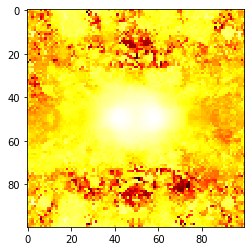

In [204]:
plt.imshow(np.log(sample1[799,0,:,:]),cmap='hot')